#  The aim of this project is to build a deep neural network capable of analyzing images captured by smartphones to quickly and accurately identify crop diseases.

We are analyzing 54,306 images of plant leaves, which are categorized into 38 class labels. Each class label corresponds to a crop-disease pair, and our goal is to predict this pair from the image of the plant leaf. These images are sourced from the dataset available at the following repository: https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.

To train our AI-based image recognition system, we will utilize this dataset. In all our experiments, we utilize three different versions of the PlantVillage dataset. We begin with the original dataset in color, then we explore a grayscale version, and finally, we conduct our experiments on a version where the leaves are segmented. This approach allows us to assess the performance and robustness of our image recognition system in various contexts. We analyze how variations such as color, grayscale, and leaf segmentation can impact the model’s results. By understanding how our system behaves under these different conditions, we can better evaluate its ability to generalize and operate effectively in real-world environments. These three versions of the data are already available via the above-mentioned link.


The different of crop disease types used in this project :

0: Grape___healthy

1: Peach___Bacterial_spot

2: Apple___healthy

3: Orange___Haunglongbing_(Citrus_greening)

4: Corn_(maize)___healthy

5: Tomato___Septoria_leaf_spot

6: Tomato___healthy

7: Corn_(maize)__Common_rust$

8: Tomato___Early_blight

9: Potato___Late_blight

10: Peach___healthy

11: Corn_(maize)___Northern_Leaf_Blight

12: Blueberry___healthy

13: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)

14: Tomato___Leaf_Mold

15: Soybean___healthy

16: Cherry_(including_sour)___healthy

17: Tomato___Spider_mites Two-spotted_spider_mite

18: Potato___healthy

19: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot

20: Cherry_(including_sour)___Powdery_mildew

21: Apple___Cedar_apple_rust

22: Squash___Powdery_mildew

23: Tomato___Late_blight

24: Grape___Black_rot

25: Pepper,_bell___healthy

26: Tomato___Target_Spot

27: Apple___Black_rot

28: Tomato___Bacterial_spot

29: Strawberry___healthy

30: Pepper,_bell___Bacterial_spot

31: Raspberry___healthy

32: Tomato___Tomato_Yellow_Leaf_Curl_Virus

33: Apple___Apple_scab

34: Potato___Early_blight

35: Tomato___Tomato_mosaic_virus

36: Strawberry___Leaf_scorch

37: Grape___Esca_(Black_Measles)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

from PIL import Image, ImageFile
from torchvision import datasets, transforms, utils
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader

from sklearn import manifold
from sklearn import decomposition
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import subprocess
import shutil

import os
import random
import time

#Understanding the data

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_folder(repo_url, clone_dir, folder_name):
    if os.path.exists(folder_name):
        os.chdir("..")
        shutil.move(os.path.join(clone_dir, folder_name), folder_name)
        print(f"Folder '{folder_name}' extracted successfully.")

        total_files = 0
        classes = []
        # Count number of files in each directory
        for root, dirs, files in os.walk(folder_name):
            for directory in dirs:
                dir_path = os.path.join(root, directory)
                classes.append(directory)
                num_files = len([name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))])
                total_files += num_files
                print(f"Directory '{directory}' contains {num_files} files.")

        print(f"Total number of files: {total_files}")

    else:
        print(f"Folder '{folder_name}' not found in the repository.")
        classes = []

    print()
    print(f"total number of classes : '{len(classes)}'.")
    print(classes)

    return classes

In [ ]:
# Clone the repository
repo_url = "https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git"
clone_dir = "plantvillage_deeplearning_paper_dataset"
subprocess.run(["git", "clone", repo_url, clone_dir])
os.chdir(clone_dir)

# Raw color images
classes = extract_folder(repo_url, clone_dir, "raw/color")

Folder 'raw/color' extracted successfully.
Directory 'Orange___Haunglongbing_(Citrus_greening)' contains 5507 files.
Directory 'Peach___Bacterial_spot' contains 2297 files.
Directory 'Raspberry___healthy' contains 371 files.
Directory 'Soybean___healthy' contains 5090 files.
Directory 'Tomato___Target_Spot' contains 1404 files.
Directory 'Pepper,_bell___Bacterial_spot' contains 997 files.
Directory 'Grape___healthy' contains 423 files.
Directory 'Potato___healthy' contains 152 files.
Directory 'Grape___Black_rot' contains 1180 files.
Directory 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' contains 5357 files.
Directory 'Tomato___Leaf_Mold' contains 952 files.
Directory 'Tomato___healthy' contains 1591 files.
Directory 'Potato___Late_blight' contains 1000 files.
Directory 'Tomato___Spider_mites Two-spotted_spider_mite' contains 1676 files.
Directory 'Grape___Esca_(Black_Measles)' contains 1383 files.
Directory 'Tomato___Septoria_leaf_spot' contains 1771 files.
Directory 'Tomato___Bacterial_s

Unbalanced Distribution: The distribution appears to be highly unbalanced. This conclusion is drawn from the significant disparity in the heights of the bars representing different crop disease classes. Some classes have a much larger number of files compared to others.

Imbalance Severity: Classes such as "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Orange___Haunglongbing_(Citrus_greening)", and "Soybean___healthy" have notably higher numbers of files compared to the rest. Conversely, classes like "Potato___healthy", "Apple___Cedar_apple_rust", and "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot" have relatively fewer files.

Impact on Model Performance: The presence of highly unbalanced classes can potentially impact the performance of machine learning models trained on this dataset. Models may have a tendency to be biased towards the majority classes, leading to poorer performance on minority classes.

Data Augmentation or Sampling Strategies: Addressing class imbalance may require techniques such as data augmentation for minority classes.

That leads to improved model performance and reduced overfitting. However, it's crucial to select augmentation techniques carefully and evaluate models appropriately to avoid introducing bias

#A. Data Preprocessing.

In [4]:
class CropDiseaseDataset(data.Dataset):
    def __init__(self, root_dir, train=True, validation=False, gray_scale=False, segmented=False):
        """Initializes a dataset containing images and labels."""
        super().__init__()
        self.gray_scale = gray_scale
        self.root_dir = root_dir
        self.train = train
        self.validation = validation
        self.segmented = segmented

        # Get all jpg images
        self.files = []
        for class_name in os.listdir(self.root_dir):
            class_dir = os.path.join(self.root_dir, class_name)
            # Filter files based on the segmented condition
            if self.segmented:
                files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(".jpg")]
            else:
                files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(".JPG")]
            self.files.extend(files)

        random.shuffle(self.files)

        # Define the split ratios
        train_ratio = 0.65
        validation_ratio = 0.15

        self.classes = []
        for root, dirs, _ in os.walk(root_dir):
            for directory in dirs:
                self.classes.append(directory)

        # Split the dataset into train, validation, and test sets
        if self.train:
            num_train_files = int(len(self.files) * train_ratio)
            self.files = self.files[:num_train_files]
        elif self.validation:
            num_train_files = int(len(self.files) * train_ratio)
            num_validation_files = int(len(self.files) * validation_ratio)
            self.files = self.files[num_train_files:num_train_files + num_validation_files]
        else:
            num_train_files = int(len(self.files) * train_ratio)
            num_validation_files = int(len(self.files) * validation_ratio)
            self.files = self.files[num_train_files + num_validation_files:]

        # Remove all invalid files
        def is_valid(filename):
            """Check that a file is not corrupted, is in RGB, and has non-zero size"""
            if os.path.getsize(filename) == 0:
                return False
            valid_extensions = ['.jpg']
            _, ext = os.path.splitext(filename)
            if ext.lower() not in valid_extensions:
                return False
            try:
                with Image.open(filename, 'r') as img:
                    img.verify()
                    mode = img.mode
                    return mode == 'RGB'
            except:
                return False

        wrong = []
        for i in range(len(self.files)):
            if not is_valid(self.files[i]):
                wrong.append(i)
        self.files = np.delete(self.files, wrong)
        random.shuffle(self.files)

        if self.gray_scale:
            self.means, self.stds = self.calculate_mean_std_gray()
            self.means = np.array(self.means)
            self.stds = np.array(self.stds)
        else:
            self.means, self.stds = self.calculate_mean_std()

        self.transform = self.get_transform()

    def calculate_mean_std(self):
        sum_channel = np.zeros(3)
        squared_sum_channel = np.zeros(3)
        total_pixels = 0
        total_images = len(self.files)

        # Iterate through all images to accumulate sums
        for file in self.files:
            img = Image.open(file)

            img_array = np.array(img)
            total_pixels += img_array.size / 3
            sum_channel += np.sum(img_array, axis=(0, 1)) / 255.0
            squared_sum_channel += np.sum((img_array / 255.0) ** 2, axis=(0, 1))

        means = sum_channel / total_pixels
        stds = np.sqrt((squared_sum_channel / total_pixels) - (means ** 2))

        return means.tolist(), stds.tolist()

    def calculate_mean_std_gray(self):
        sum_channel = np.zeros(1)  # Grayscale has only one channel
        squared_sum_channel = np.zeros(1)
        total_pixels = 0
        total_images = len(self.files)

        # Iterate through all images to accumulate sums
        for file in self.files:
            img = Image.open(file).convert("L")  # Convert image to grayscale

            img_array = np.array(img)
            total_pixels += img_array.size
            sum_channel += np.sum(img_array) / 255.0
            squared_sum_channel += np.sum((img_array / 255.0) ** 2)

        means = sum_channel / total_pixels
        stds = np.sqrt((squared_sum_channel / total_pixels) - (means ** 2))

        return [means], [stds]

    def get_transform(self):
        if self.gray_scale:
            return transforms.Compose([
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([
                    transforms.ColorJitter(
                        brightness=torch.rand(1).item(),
                        contrast=torch.rand(1).item(),
                        saturation=torch.rand(1).item(),
                        hue=torch.rand(1).item() * 0.5,
                    )
                ]),
                transforms.Resize((120, 120)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
                transforms.ToTensor(),
                transforms.Normalize(self.means, self.stds)
            ])
        else:
            return transforms.Compose([
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomApply([
                    transforms.ColorJitter(
                        brightness=torch.rand(1).item(),
                        contrast=torch.rand(1).item(),
                        saturation=torch.rand(1).item(),
                        hue=torch.rand(1).item() * 0.5,
                    )
                ]),
                transforms.Resize((120, 120)),
                transforms.ToTensor(),
                transforms.Normalize(self.means, self.stds)
            ])

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.files)

    def __getitem__(self, index):
        """Returns the index-th data item of the dataset."""
        if index < 0 or index >= self.__len__():
            raise IndexError(
                'Wrong index (must be in [{}, {}], given: {})'
                .format(0, self.__len__(), index)
            )

        # Load image and transform
        img = Image.open(self.files[index])
        img = self.transform(img)

        # Get label
        class_name = os.path.basename(os.path.dirname(self.files[index]))
        label = self.classes.index(class_name)

        return img, torch.tensor(label)

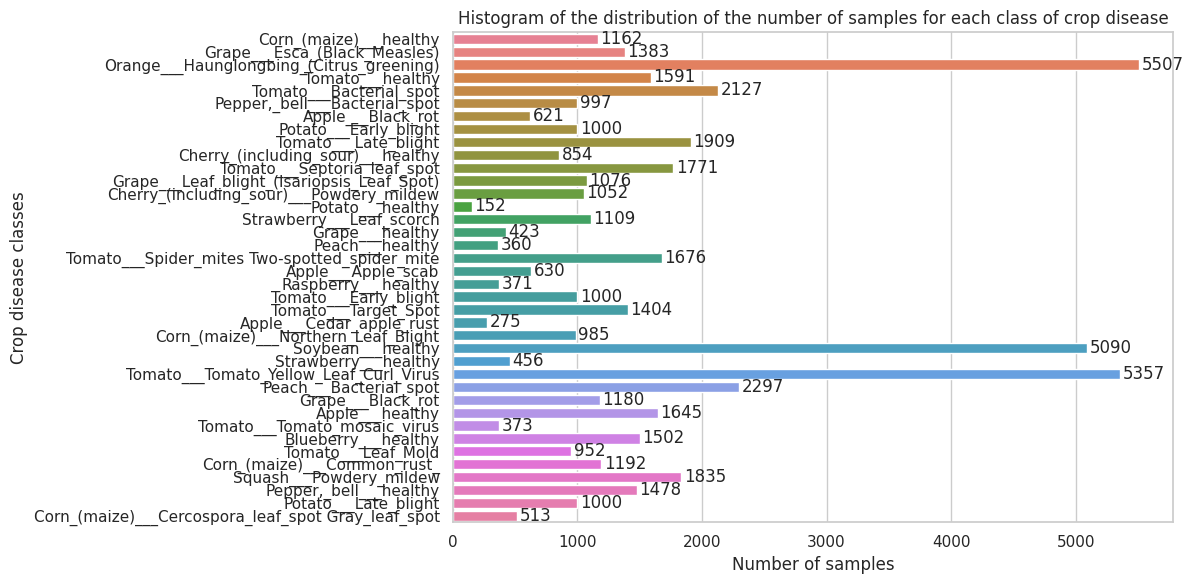

In [ ]:
# Provided data: directory names and corresponding file counts
data_ = {
    'Corn_(maize)___healthy': 1162,
    'Grape___Esca_(Black_Measles)': 1383,
    'Orange___Haunglongbing_(Citrus_greening)': 5507,
    'Tomato___healthy': 1591,
    'Tomato___Bacterial_spot': 2127,
    'Pepper,_bell___Bacterial_spot': 997,
    'Apple___Black_rot': 621,
    'Potato___Early_blight': 1000,
    'Tomato___Late_blight': 1909,
    'Cherry_(including_sour)___healthy': 854,
    'Tomato___Septoria_leaf_spot': 1771,
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076,
    'Cherry_(including_sour)___Powdery_mildew': 1052,
    'Potato___healthy': 152,
    'Strawberry___Leaf_scorch': 1109,
    'Grape___healthy': 423,
    'Peach___healthy': 360,
    'Tomato___Spider_mites Two-spotted_spider_mite': 1676,
    'Apple___Apple_scab': 630,
    'Raspberry___healthy': 371,
    'Tomato___Early_blight': 1000,
    'Tomato___Target_Spot': 1404,
    'Apple___Cedar_apple_rust': 275,
    'Corn_(maize)___Northern_Leaf_Blight': 985,
    'Soybean___healthy': 5090,
    'Strawberry___healthy': 456,
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357,
    'Peach___Bacterial_spot': 2297,
    'Grape___Black_rot': 1180,
    'Apple___healthy': 1645,
    'Tomato___Tomato_mosaic_virus': 373,
    'Blueberry___healthy': 1502,
    'Tomato___Leaf_Mold': 952,
    'Corn_(maize)___Common_rust_': 1192,
    'Squash___Powdery_mildew': 1835,
    'Pepper,_bell___healthy': 1478,
    'Potato___Late_blight': 1000,
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513
}

directories = list(data_.keys())
file_counts = list(data_.values())
colors = sns.color_palette("husl", len(directories))

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=file_counts, y=directories, hue=directories, dodge=False, palette=colors, legend=False)
for i, count in enumerate(file_counts):
    plt.text(count + 20, i, str(count), va='center')

plt.xlabel('Number of samples')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease')
plt.tight_layout()
plt.show()

In [ ]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

Checking out.

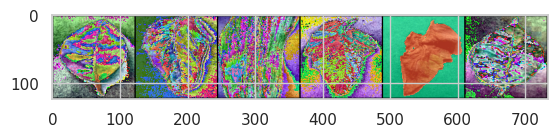

Orange___Haunglongbing_(Citrus_greening) Tomato___Bacterial_spot Corn_(maize)___Northern_Leaf_Blight Tomato___Bacterial_spot Tomato___Late_blight Cherry_(including_sour)___Powdery_mildew


In [ ]:
extracted_folder = "raw/color"
my_dataset = CropDiseaseDataset(root_dir=extracted_folder, train=True, gray_scale=False, segmented = False)
train_loader = DataLoader(my_dataset, batch_size=6, shuffle=True, num_workers=2)

images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))
print(*[classes[l] for l in labels])

Tomato___Tomato_Yellow_Leaf_Curl_Virus Soybean___healthy Grape___Esca_(Black_Measles) Orange___Haunglongbing_(Citrus_greening) Apple___healthy Pepper,_bell___healthy


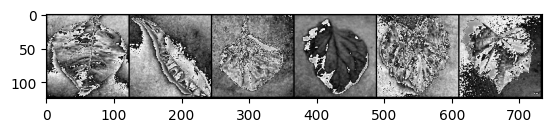

Pepper,_bell___healthy Peach___Bacterial_spot Soybean___healthy Tomato___Tomato_Yellow_Leaf_Curl_Virus Grape___Black_rot Grape___Black_rot


In [ ]:
my_dataset = CropDiseaseDataset(root_dir=extracted_folder, train=True, gray_scale=True, segmented= False)
train_loader = DataLoader(my_dataset, batch_size=6, shuffle=True, num_workers=2)

images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))
print(*[my_dataset.classes[l] for l in labels])

#B. Defining the convolutional network architecture.

Initialize our parameters, determine the number of model parameters and a function to tell us how long an epoch takes.

In [5]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [6]:
class CNN(nn.Module):
    def __init__(self, grayscale=False):
        super(CNN, self).__init__()
        if grayscale:
            in_channels = 1  # Set input channels to 1 for grayscale images
        else:
            in_channels = 3  # Keep input channels as 3 for RGB images
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 38)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=38, bias=True)
)


# C. Optimization stage (hyperparameter selections)

In [ ]:
# Spliiting the dataset
extracted_folder = "raw/color"
train_set = CropDiseaseDataset(root_dir=extracted_folder, train=True, validation=False, gray_scale=False, segmented=False)
validation_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=True, gray_scale=False, segmented=False)
test_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=False, gray_scale=False, segmented=False)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
print(f"Train set: '{len(train_set)}' images,", f"Validation set: '{len(validation_set)}' images,", f"Test set: '{len(test_set)}' images")

Train set: '34321' images, Validation set: '7920' images, Test set: '10562' images


In [ ]:
merged_dataset = ConcatDataset([train_set, validation_set, test_set])

# Create a single loader for the combined dataset
mergedloader = DataLoader(merged_dataset, batch_size=64, shuffle=True, num_workers=2)

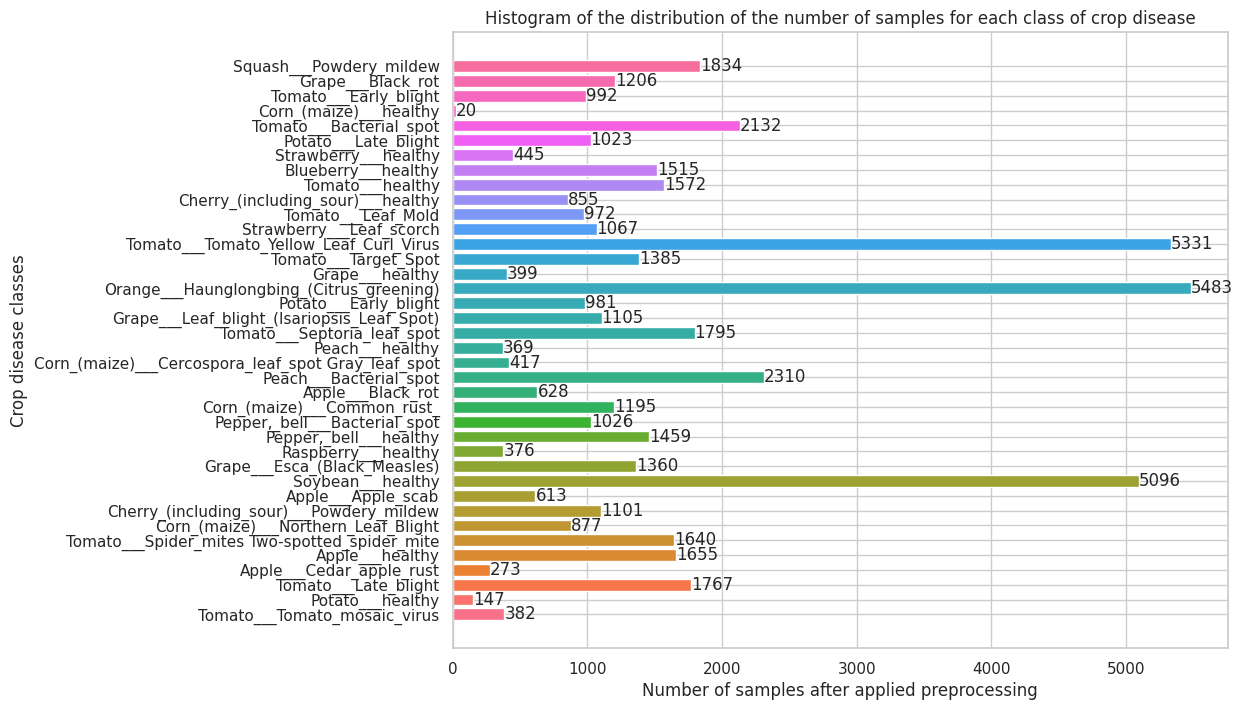

In [ ]:
class_counts = defaultdict(int)
for images, labels in mergedloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))

class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples after applied preprocessing')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [7]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

# Define the training method
def train(model, num_epochs, trainloader, testloader, criterion, optimizer, validation_phase=False):
    train_avg_loss = []
    test_avg_loss = []
    test_accuracy = []
    train_accuracy = []

    for i in range(num_epochs):
        train_losses = []
        test_losses = []
        correct_train = 0
        total_train = 0

        for x, y in trainloader:
            start_time = time.monotonic()
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = criterion(pred, y)
            train_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            y_pred_train = pred.argmax(dim=-1)
            correct_train += (y_pred_train == y).sum().item()
            total_train += y.size(0)

        with torch.no_grad():
            correct_test = 0
            total_test = 0

            # Choose loader based on phase
            if validation_phase:
                loader = validationloader
            else:
                loader = testloader

            for x, y in loader:
                x, y = x.to(device), y.to(device)

                pred = model(x)
                loss = criterion(pred, y)
                test_losses.append(loss)

                y_pred_test = pred.argmax(dim=-1)
                correct_test += (y_pred_test == y).sum().item()
                total_test += y.size(0)

            # Compute accuracy
            accuracy_train = correct_train / total_train
            accuracy_test = correct_test / total_test
            test_accuracy.append(accuracy_test)

        train_avg_loss.append(torch.mean(torch.tensor(train_losses)).detach())
        test_avg_loss.append(torch.mean(torch.tensor(test_losses)).detach())

        if validation_phase:
            print("Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(
                i+1, num_epochs, test_avg_loss[-1], accuracy_test*100, train_avg_loss[-1], accuracy_train*100))
        else:
            print("Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(
                i+1, num_epochs, test_avg_loss[-1], accuracy_test*100, train_avg_loss[-1], accuracy_train*100))

        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'| Epoch Time: {epoch_mins}m {epoch_secs}s')

        train_accuracy.append(accuracy_train)

    # Save the model at the end of the training
    torch.save(model.state_dict(), 'model.pt')

    return train_avg_loss, test_avg_loss, test_accuracy, train_accuracy

In [8]:
# define a method for plotting the results
def plot_training_results(train_avg_loss, validation_avg_loss, train_accuracy, validation_accuracy, is_validation=True):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    if is_validation:
        loss_label = 'Validation Loss'
        accuracy_label = 'Validation Accuracy'
    else:
        loss_label = 'Test Loss'
        accuracy_label = 'Test Accuracy'

    # Plot train and validation/test loss
    ax1.plot(train_avg_loss, label='Train Loss')
    ax1.plot(validation_avg_loss, label=loss_label)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # Plot validation/test accuracy
    ax2.plot(validation_accuracy, label=accuracy_label)
    ax2.plot(train_accuracy, label='Train Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper left')

    plt.show()

Learning rate selection

In [ ]:
num_epochs = 20
learning_rates = [1e-3,1e-2,1e-4]

# Lists to store results for each learning rate
train_losses_list = []
validation_losses_list = []
train_accuracy_list = []
validation_accuracy_list = []

for idx,lr in enumerate(learning_rates):
    network = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(network.parameters(), lr=lr)

    print(f"Training model for configuration {idx+ 1}...")
    # Train the model
    train_avg_loss, validation_avg_loss, validation_accuracy, train_accuracy = train(network, num_epochs, trainloader, validationloader, criterion, optimizer,validation_phase=True)

    # Store results for plotting
    train_losses_list.append(train_avg_loss)
    validation_losses_list.append(validation_avg_loss)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(validation_accuracy)

Training model for configuration 1...
Epoch [1/20], Validation Loss: 1.1557, Validation Accuracy: 65.19%, Train Loss: 1.9920, Train Accuracy: 45.28%
| Epoch Time: 0m 36s
Epoch [2/20], Validation Loss: 0.6847, Validation Accuracy: 77.85%, Train Loss: 0.9250, Train Accuracy: 71.22%
| Epoch Time: 0m 36s
Epoch [3/20], Validation Loss: 0.4793, Validation Accuracy: 84.39%, Train Loss: 0.6446, Train Accuracy: 79.49%
| Epoch Time: 0m 35s
Epoch [4/20], Validation Loss: 0.4588, Validation Accuracy: 85.06%, Train Loss: 0.5095, Train Accuracy: 83.55%
| Epoch Time: 0m 35s
Epoch [5/20], Validation Loss: 0.3131, Validation Accuracy: 89.44%, Train Loss: 0.4359, Train Accuracy: 85.84%
| Epoch Time: 0m 36s
Epoch [6/20], Validation Loss: 0.3292, Validation Accuracy: 89.00%, Train Loss: 0.3662, Train Accuracy: 87.85%
| Epoch Time: 0m 37s
Epoch [7/20], Validation Loss: 0.3100, Validation Accuracy: 89.90%, Train Loss: 0.3319, Train Accuracy: 89.07%
| Epoch Time: 0m 36s
Epoch [8/20], Validation Loss: 0.3023,

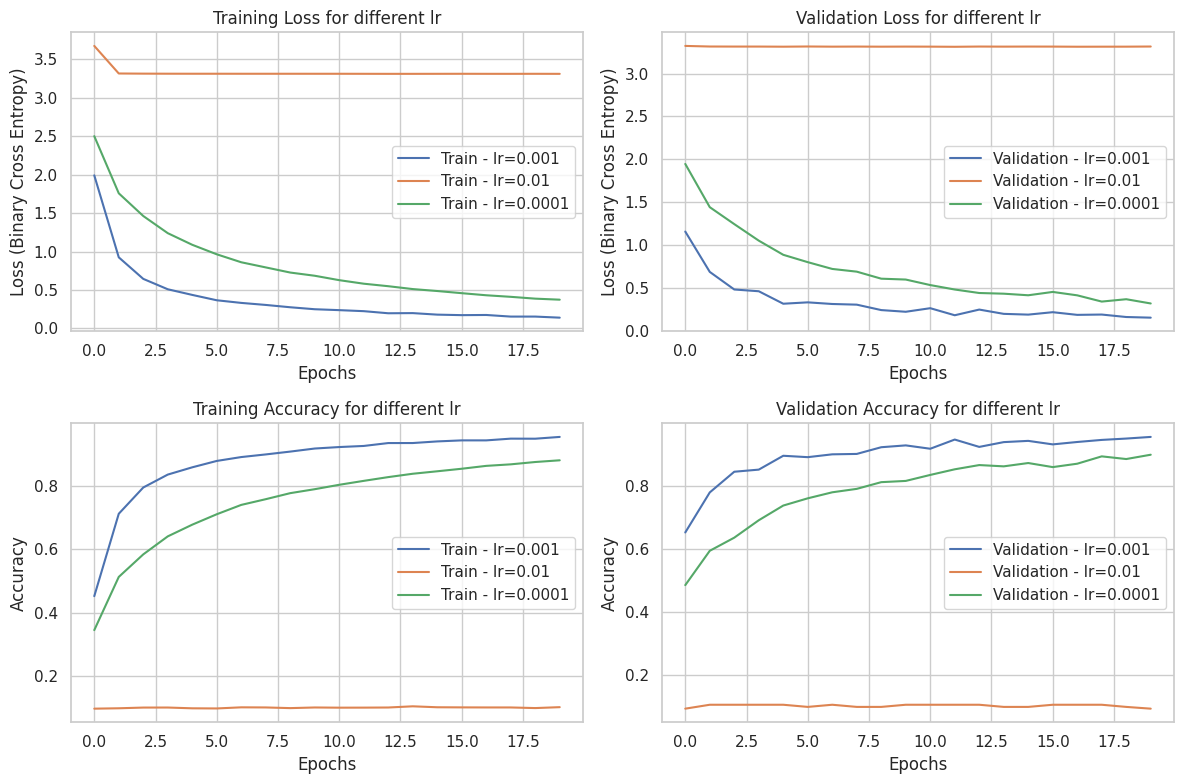

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, lr in enumerate(learning_rates):
    axs[0].plot(train_losses_list[i], label=f'Train - 1e^{int(np.log10(lr))}', linestyle='-', linewidth=2)
    axs[0].plot(validation_losses_list[i], label=f'Validation - 1e^{int(np.log10(lr))}', linestyle='--', linewidth=2)

axs[0].set_title('Loss for different Learning Rates')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Accuracy plot
for i, lr in enumerate(learning_rates):
    axs[1].plot(train_accuracy_list[i], label=f'Train - 1e^{int(np.log10(lr))}', linestyle='-', linewidth=2)
    axs[1].plot(validation_accuracy_list[i], label=f'Validation - 1e^{int(np.log10(lr))}', linestyle='--', linewidth=2)

axs[1].set_title('Accuracy for different Learning Rates')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

The best learning among those which are tested is $10^{-3}$.

Optimizer selection

In [ ]:
num_epochs = 18
learning_rate = 1e-3
optimizers = ['RMSprop','Adam','SGD']

# Lists to store results for each learning rate
train_losses_list = []
validation_losses_list = []
train_accuracy_list = []
validation_accuracy_list = []

for idx, optimizer_name in enumerate(optimizers):
    network = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    print(f"Training model for configuration {idx+ 1}...")
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)

    # Train the model
    train_avg_loss, validation_avg_loss, validation_accuracy, train_accuracy = train(network, num_epochs, trainloader, validationloader, criterion, optimizer,validation_phase=True)

    # Store results for plotting
    train_losses_list.append(train_avg_loss)
    validation_losses_list.append(validation_avg_loss)
    train_accuracy_list.append(train_accuracy)
    validation_accuracy_list.append(validation_accuracy)

Training model for configuration 1...
Epoch [1/18], Validation Loss: 2.3102, Validation Accuracy: 37.93%, Train Loss: 2.6718, Train Accuracy: 29.80%
| Epoch Time: 0m 35s
Epoch [2/18], Validation Loss: 1.6797, Validation Accuracy: 54.92%, Train Loss: 1.4774, Train Accuracy: 56.45%
| Epoch Time: 0m 35s
Epoch [3/18], Validation Loss: 1.5975, Validation Accuracy: 61.59%, Train Loss: 0.9859, Train Accuracy: 69.38%
| Epoch Time: 0m 35s
Epoch [4/18], Validation Loss: 0.9087, Validation Accuracy: 73.72%, Train Loss: 0.7607, Train Accuracy: 75.72%
| Epoch Time: 0m 34s
Epoch [5/18], Validation Loss: 0.9755, Validation Accuracy: 73.48%, Train Loss: 0.6256, Train Accuracy: 79.81%
| Epoch Time: 0m 35s
Epoch [6/18], Validation Loss: 1.4048, Validation Accuracy: 65.20%, Train Loss: 0.5347, Train Accuracy: 82.70%
| Epoch Time: 0m 34s
Epoch [7/18], Validation Loss: 0.6019, Validation Accuracy: 81.35%, Train Loss: 0.4708, Train Accuracy: 84.70%
| Epoch Time: 0m 37s
Epoch [8/18], Validation Loss: 0.6055,

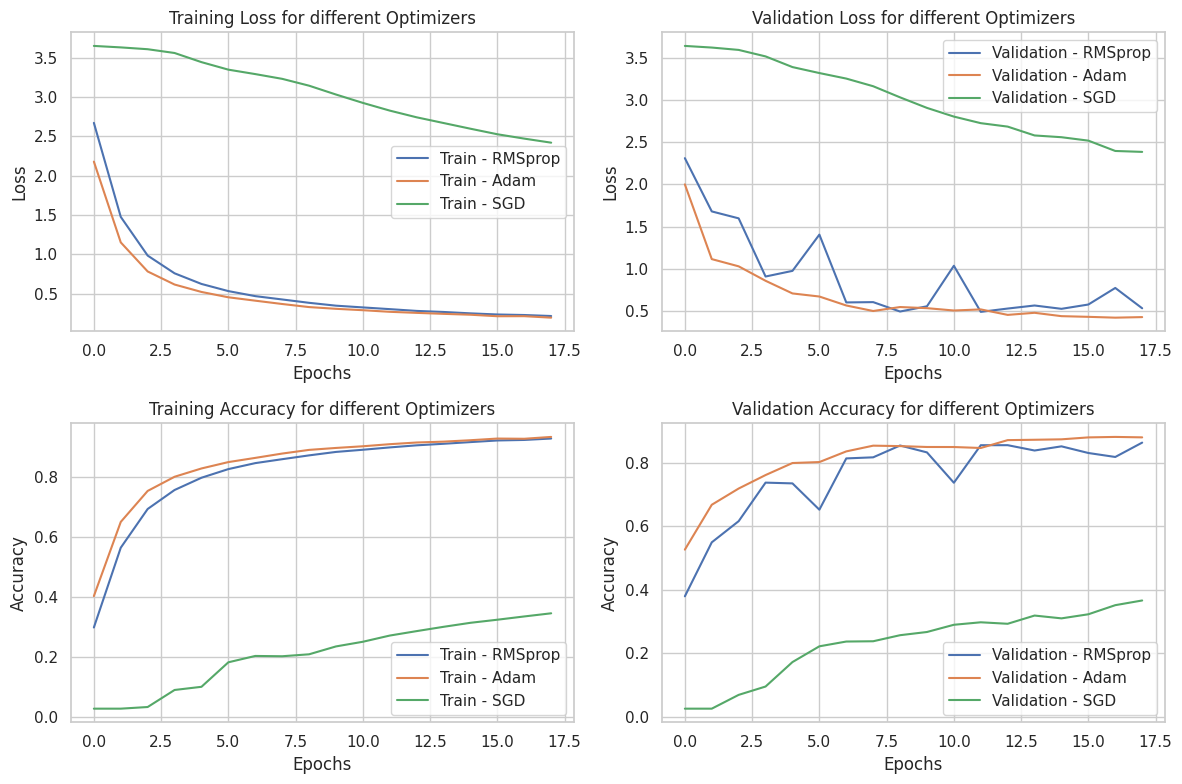

In [ ]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
for i, optimizer_name in enumerate(optimizers):
    axs[0].plot(train_losses_list[i], label=f'Train - {optimizer_name}', linestyle='-', linewidth=2)
    axs[0].plot(validation_losses_list[i], label=f'Validation - {optimizer_name}', linestyle='--', linewidth=2)

axs[0].set_title('Loss for different Optimizers')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

# Accuracy plot
for i, optimizer_name in enumerate(optimizers):
    axs[1].plot(train_accuracy_list[i], label=f'Train - {optimizer_name}', linestyle='-', linewidth=2)
    axs[1].plot(validation_accuracy_list[i], label=f'Validation - {optimizer_name}', linestyle='--', linewidth=2)

axs[1].set_title('Accuracy for different Optimizers')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# D. 1) Train the model over the color images

In [ ]:
# Define hyperparameters
learning_rate = 1e-3
num_epochs = 25

network = CNN(grayscale=False).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(network):,} trainable parameters')

The model has 6,846,758 trainable parameters


In [ ]:
# Train the model
train_avg_loss, validation_avg_loss, validation_accuracy, train_accuracy = train(network, num_epochs, trainloader, validationloader, criterion, optimizer,validation_phase=True)

Epoch [1/25], Validation Loss: 1.4615, Validation Accuracy: 58.85%, Train Loss: 2.3124, Train Accuracy: 43.75%
| Epoch Time: 0m 37s
Epoch [2/25], Validation Loss: 1.0188, Validation Accuracy: 69.18%, Train Loss: 1.1620, Train Accuracy: 65.64%
| Epoch Time: 0m 39s
Epoch [3/25], Validation Loss: 0.8718, Validation Accuracy: 73.94%, Train Loss: 0.8393, Train Accuracy: 74.28%
| Epoch Time: 0m 37s
Epoch [4/25], Validation Loss: 0.6697, Validation Accuracy: 78.94%, Train Loss: 0.6684, Train Accuracy: 78.97%
| Epoch Time: 0m 39s
Epoch [5/25], Validation Loss: 0.6270, Validation Accuracy: 80.62%, Train Loss: 0.5629, Train Accuracy: 82.14%
| Epoch Time: 0m 37s
Epoch [6/25], Validation Loss: 0.5899, Validation Accuracy: 82.12%, Train Loss: 0.5014, Train Accuracy: 84.00%
| Epoch Time: 0m 39s
Epoch [7/25], Validation Loss: 0.5024, Validation Accuracy: 84.08%, Train Loss: 0.4372, Train Accuracy: 85.80%
| Epoch Time: 0m 39s
Epoch [8/25], Validation Loss: 0.5205, Validation Accuracy: 84.37%, Train Lo

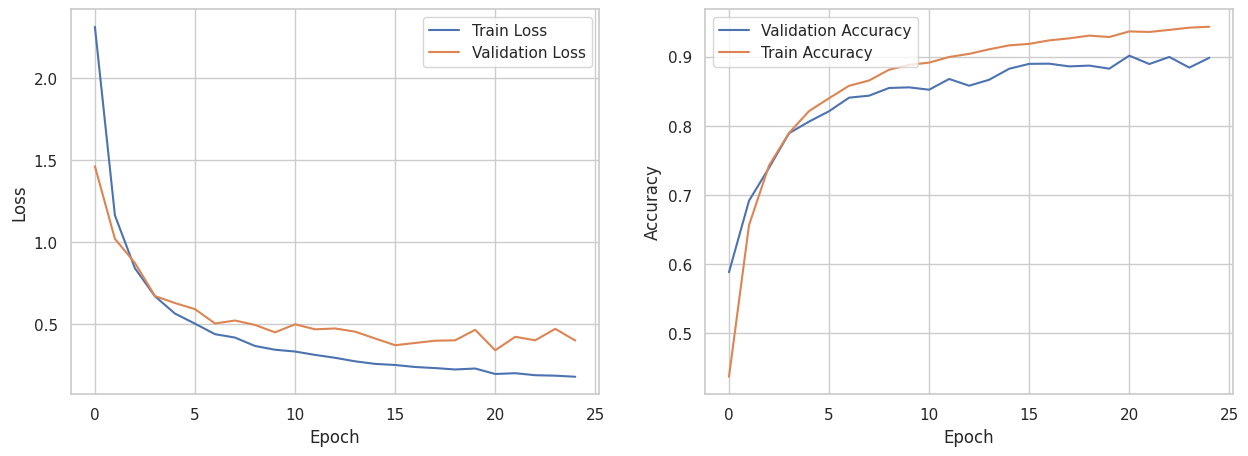

In [ ]:
plot_training_results(train_avg_loss, validation_avg_loss,train_accuracy, validation_accuracy, is_validation=True)

In [ ]:
# Combining train and validation datasets for testing the model
combined_train_set = ConcatDataset([train_set, validation_set])
combined_train_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Test the model
network = CNN(grayscale=False).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_avg_loss, test_avg_loss, test_accuracy, train_accuracy = train(network, num_epochs, combined_train_loader, testloader, criterion, optimizer,validation_phase=False)

Epoch [1/25], Test Loss: 1.4136, Test Accuracy: 60.75%, Train Loss: 2.3014, Train Accuracy: 42.66%
| Epoch Time: 0m 52s
Epoch [2/25], Test Loss: 1.3749, Test Accuracy: 62.82%, Train Loss: 1.1568, Train Accuracy: 66.19%
| Epoch Time: 0m 54s
Epoch [3/25], Test Loss: 0.8314, Test Accuracy: 75.10%, Train Loss: 0.8253, Train Accuracy: 74.65%
| Epoch Time: 0m 51s
Epoch [4/25], Test Loss: 0.7123, Test Accuracy: 78.43%, Train Loss: 0.6460, Train Accuracy: 80.14%
| Epoch Time: 0m 50s
Epoch [5/25], Test Loss: 0.4824, Test Accuracy: 84.46%, Train Loss: 0.5521, Train Accuracy: 82.48%
| Epoch Time: 0m 53s
Epoch [6/25], Test Loss: 0.4509, Test Accuracy: 85.34%, Train Loss: 0.4613, Train Accuracy: 85.11%
| Epoch Time: 0m 55s
Epoch [7/25], Test Loss: 0.4021, Test Accuracy: 86.73%, Train Loss: 0.4072, Train Accuracy: 86.89%
| Epoch Time: 0m 54s
Epoch [8/25], Test Loss: 0.4022, Test Accuracy: 87.31%, Train Loss: 0.3667, Train Accuracy: 88.04%
| Epoch Time: 0m 50s
Epoch [9/25], Test Loss: 0.3563, Test Ac

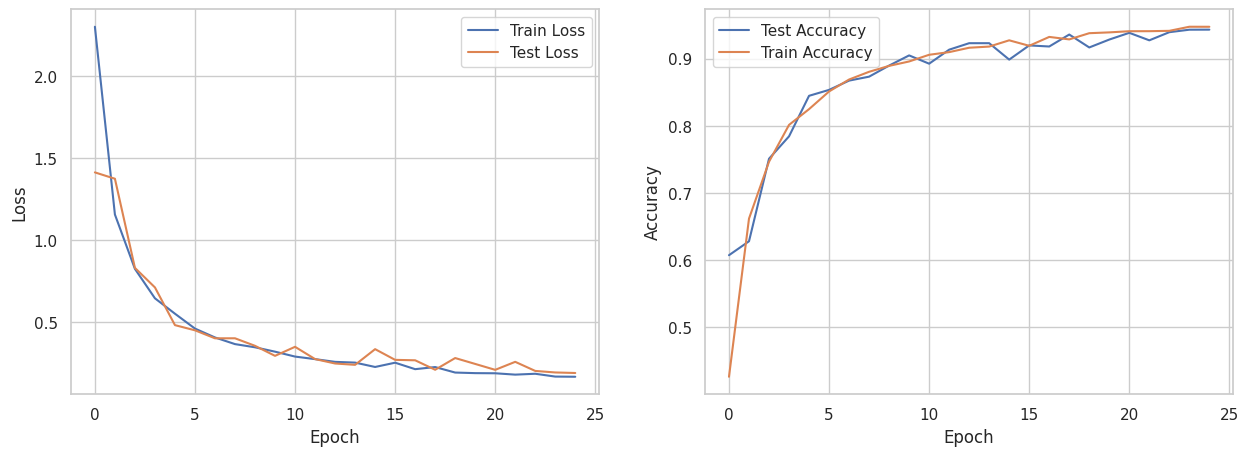

In [ ]:
plot_training_results(train_avg_loss, test_avg_loss,train_accuracy, test_accuracy, is_validation=False)

Examining the model


In [ ]:
network.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [9]:
def get_predictions(model, iterator, device):
    model.eval()
    model.to(device)

    images = []
    labels = []
    probs = []
    corrects = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            if isinstance(outputs, tuple):
                y_pred = outputs[0]
            else:
                y_pred = outputs

            y_prob = F.softmax(y_pred, dim=-1)
            _, predicted = torch.max(y_prob, 1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

            # Determine correctness of predictions
            correct = predicted.eq(y)
            corrects.extend(correct.cpu().tolist())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs, corrects

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels, probs, corrects = get_predictions(network, testloader, device)
pred_labels = torch.argmax(probs, 1)

print(f"There are {len(corrects)} correct predictions.")

There are 10562 correct predictions.


In [10]:
# Define the plot_confusion_matrix function
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(17, 17))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(38))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

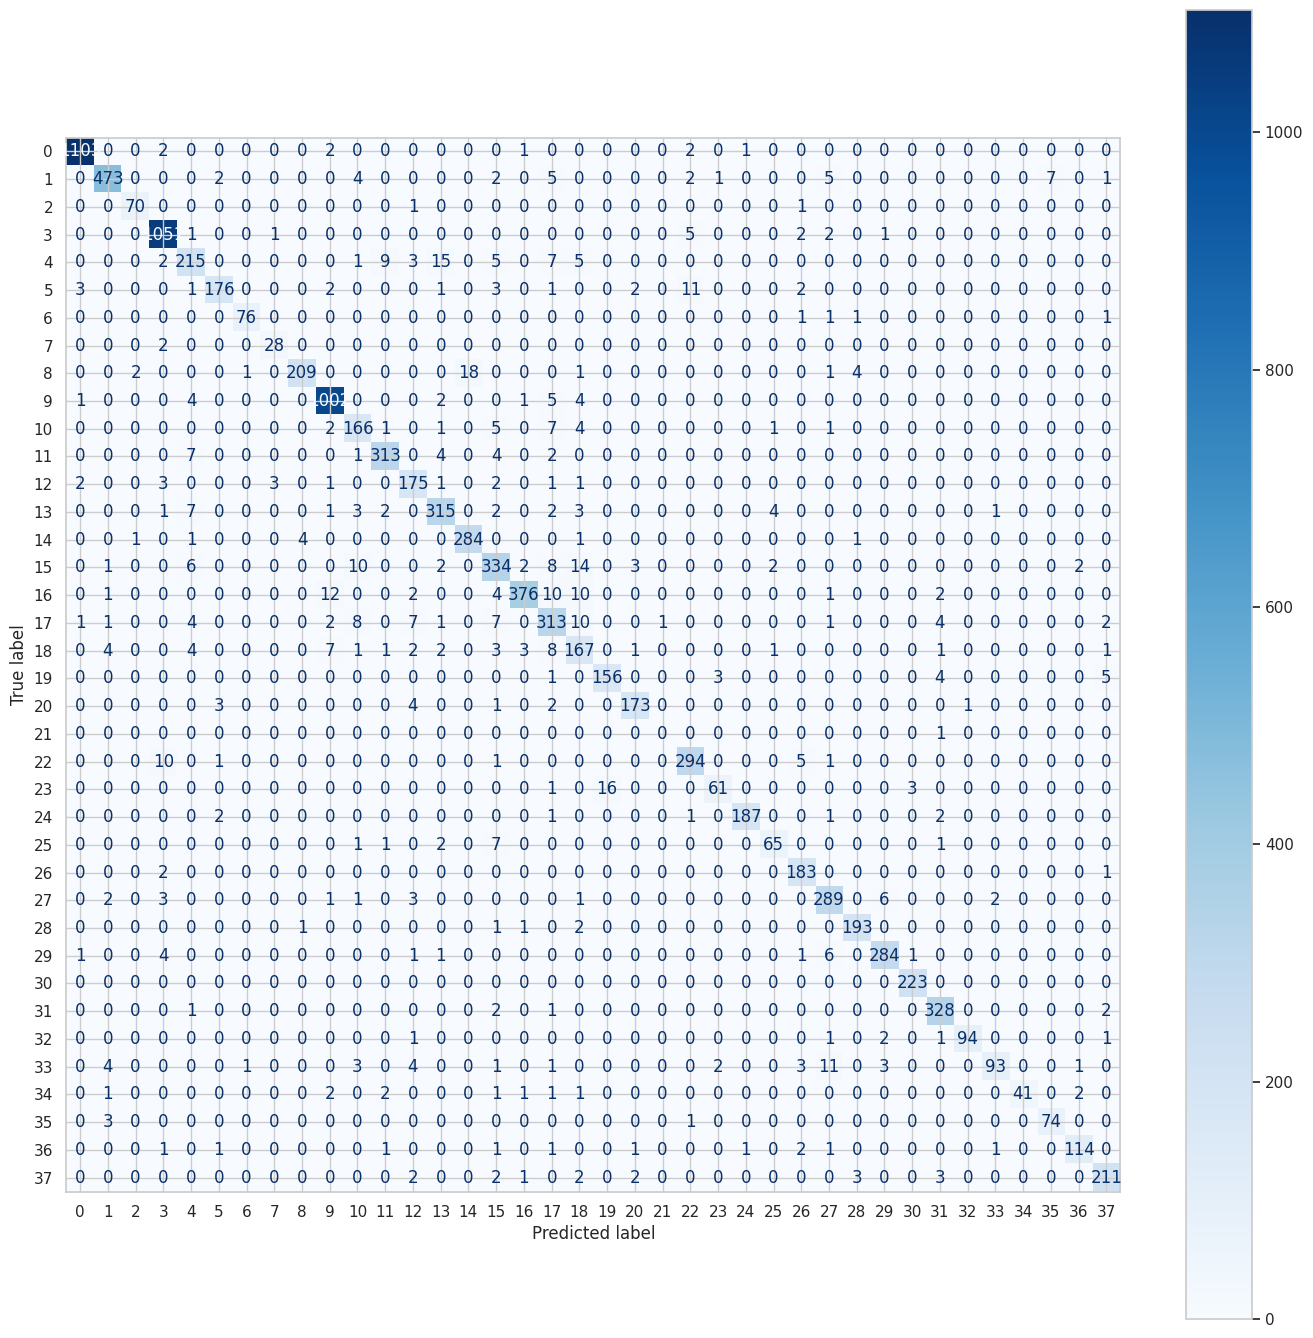

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
# Now, extract and sort incorrect examples
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)
print(f"There are {len(incorrect_examples)} incorrect predictions.")

There are 653 incorrect predictions.


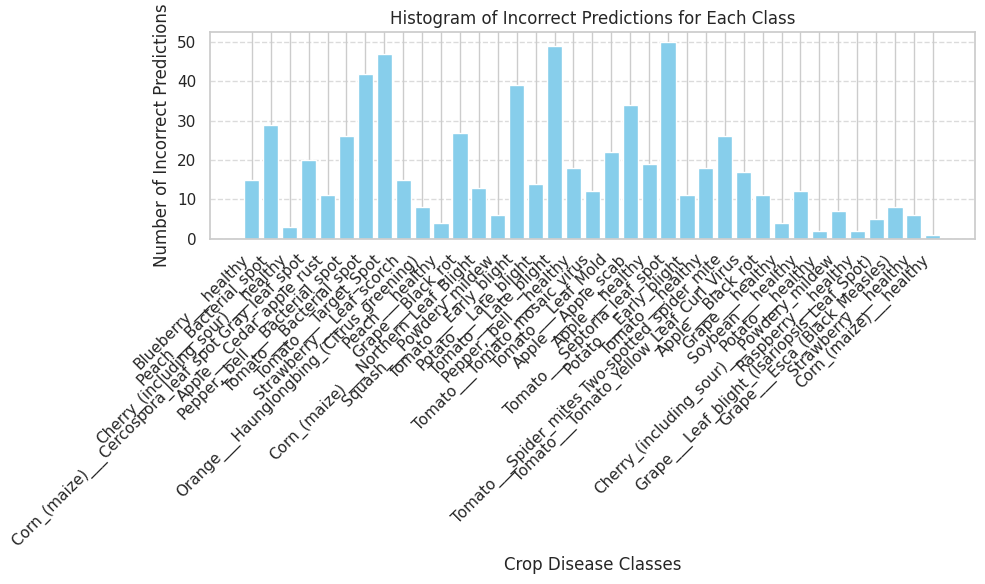

In [ ]:
incorrect_counts = {}

# Count the occurrences of each class label in the incorrect examples
for _, label, _ in incorrect_examples:
    if label.item() not in incorrect_counts:
        incorrect_counts[label.item()] = 1
    else:
        incorrect_counts[label.item()] += 1

class_names = [train_set.classes[label] for label in incorrect_counts.keys()]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_names, incorrect_counts.values(), color='skyblue')
plt.xlabel('Crop Disease Classes')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Histogram of Incorrect Predictions for Each Class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
data = {'Class Name': class_names, 'Incorrect Counts': list(incorrect_counts.values())}
df1 = pd.DataFrame(data)
df1.head(5)

Class Name  Incorrect Counts
0                                Blueberry___healthy                15
1                             Peach___Bacterial_spot                29
2                  Cherry_(including_sour)___healthy                 3
3  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...                20
4                           Apple___Cedar_apple_rust                11

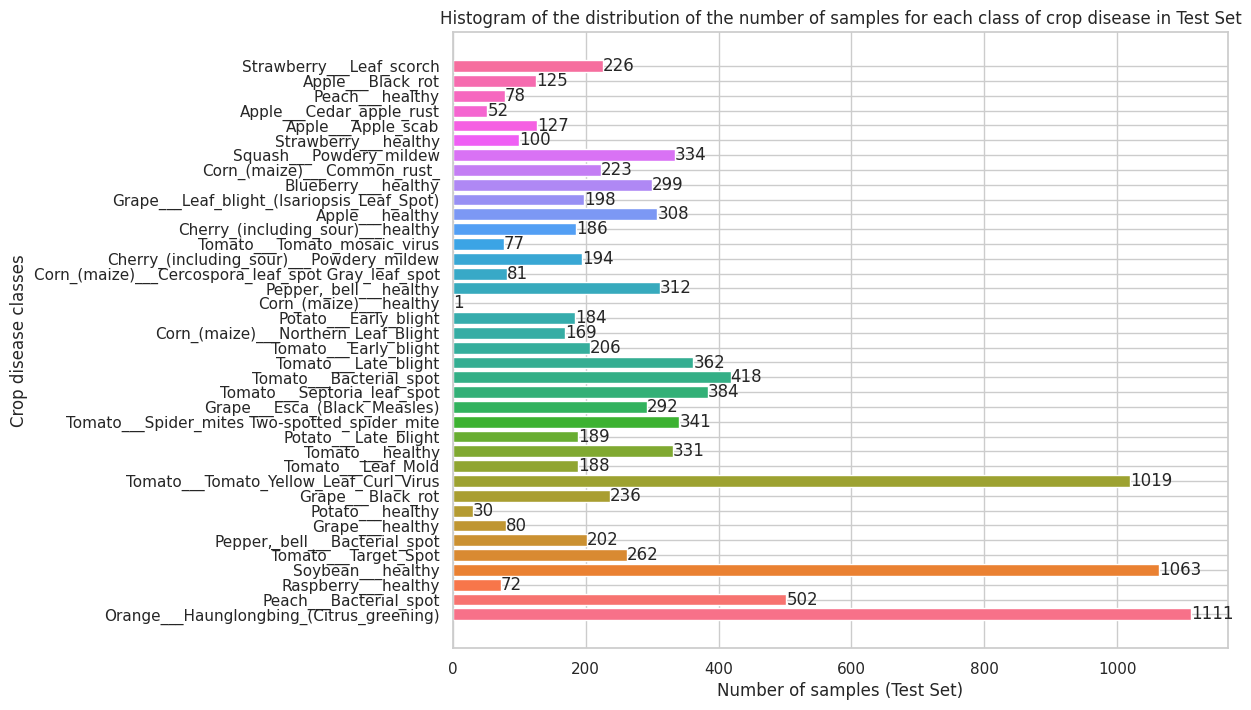

In [ ]:
class_counts = defaultdict(int)
for images, labels in testloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))


class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples (Test Set)')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease in Test Set')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [ ]:
data = {'Class Name': class_names, 'Counts': counts}
df2 = pd.DataFrame(data)
df2.head(5)

Class Name  Counts
0  Orange___Haunglongbing_(Citrus_greening)    1111
1                    Peach___Bacterial_spot     502
2                       Raspberry___healthy      72
3                         Soybean___healthy    1063
4                      Tomato___Target_Spot     262

In [ ]:
merged_df = pd.merge(df1, df2, on='Class Name', suffixes=('_incorrect', '_test'))
merged_df.head(3)

Class Name  Incorrect Counts  Counts
0                Blueberry___healthy                15     299
1             Peach___Bacterial_spot                29     502
2  Cherry_(including_sour)___healthy                 3     186

In [ ]:
# Calculate the rate of success for each class in percentage
merged_df['Success Rate (%)'] = ((merged_df['Counts'] - merged_df['Incorrect Counts']) / merged_df['Counts']) * 100
merged_df

Class Name  Incorrect Counts  \
0                                 Blueberry___healthy                15   
1                              Peach___Bacterial_spot                29   
2                   Cherry_(including_sour)___healthy                 3   
3   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...                20   
4                            Apple___Cedar_apple_rust                11   
5                       Pepper,_bell___Bacterial_spot                26   
6                             Tomato___Bacterial_spot                42   
7                                Tomato___Target_Spot                47   
8                            Strawberry___Leaf_scorch                15   
9            Orange___Haunglongbing_(Citrus_greening)                 8   
10                                    Peach___healthy                 4   
11                                  Grape___Black_rot                27   
12                Corn_(maize)___Northern_Leaf_Blight                13   
13                            Squash___Powdery_mildew                 6   
14                              Tomato___Early_blight                39   
15                               Potato___Late_blight                14   
16                               Tomato___Late_blight                49   
17                             Pepper,_bell___healthy                18   
18                       Tomato___Tomato_mosaic_virus                12   
19                                 Tomato___Leaf_Mold                22   
20                                 Apple___Apple_scab                34   
21                                    Apple___healthy                19   
22                        Tomato___Septoria_leaf_spot                50   
23                              Potato___Early_blight                11   
24                                   Tomato___healthy                18   
25      Tomato___Spider_mites Two-spotted_spider_mite                26   
26             Tomato___Tomato_Yellow_Leaf_Curl_Virus                17   
27                                  Apple___Black_rot                11   
28                                    Grape___healthy                 4   
29                                  Soybean___healthy                12   
30                                   Potato___healthy                 2   
31           Cherry_(including_sour)___Powdery_mildew                 7   
32                                Raspberry___healthy                 2   
33         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                 5   
34                       Grape___Esca_(Black_Measles)                 8   
35                               Strawberry___healthy                 6   
36                             Corn_(maize)___healthy                 1   

    Counts  Success Rate (%)  
0      299         94.983278  
1      502         94.223108  
2      186         98.387097  
3       81         75.308642  
4       52         78.846154  
5      202         87.128713  
6      418         89.952153  
7      262         82.061069  
8      226         93.362832  
9     1111         99.279928  
10      78         94.871795  
11     236         88.559322  
12     169         92.307692  
13     334         98.203593  
14     206         81.067961  
15     189         92.592593  
16     362         86.464088  
17     312         94.230769  
18      77         84.415584  
19     188         88.297872  
20     127         73.228346  
21     308         93.831169  
22     384         86.979167  
23     184         94.021739  
24     331         94.561934  
25     341         92.375367  
26    1019         98.331698  
27     125         91.200000  
28      80         95.000000  
29    1063         98.871119  
30      30         93.333333  
31     194         96.391753  
32      72         97.222222  
33     198         97.474747  
34     292         97.260274  
35     100         94.000000  
36       1          0.000000

In [11]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)

        # Normalize image tensor to [0, 1]
        image = image.permute(1, 2, 0).cpu().numpy()
        image_min, image_max = np.min(image), np.max(image)
        image = (image - image_min) / (image_max - image_min)

        ax.imshow(image, cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label.item()} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

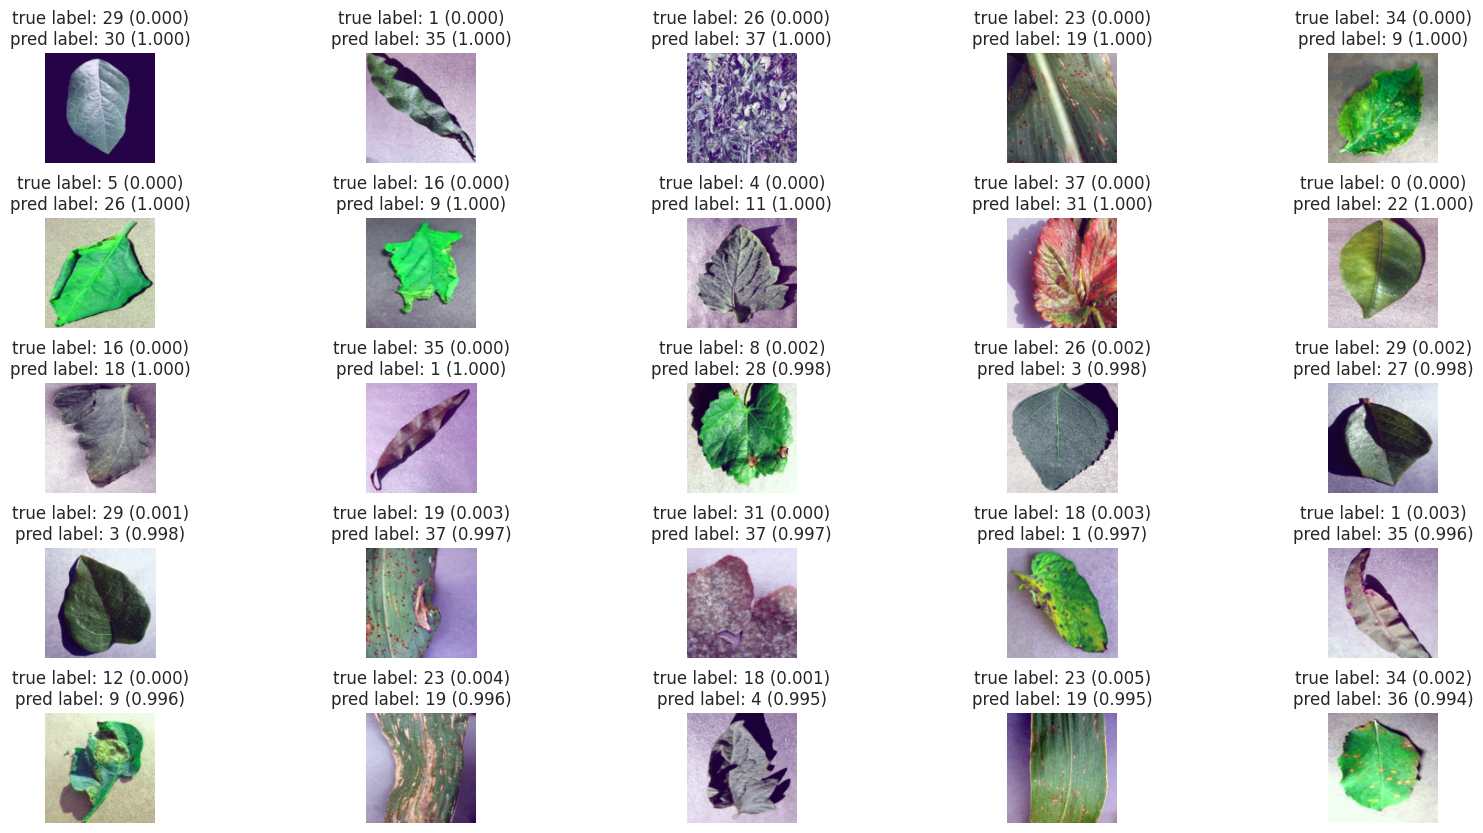

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

# D. 2) Train the model over the grey images

In [ ]:
# Clone the repository
repo_url = "https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git"
clone_dir = "plantvillage_deeplearning_paper_dataset"
subprocess.run(["git", "clone", repo_url, clone_dir])
os.chdir(clone_dir)

# Raw color images
classes = extract_folder(repo_url, clone_dir, "raw/color")

Folder 'raw/color' extracted successfully.
Directory 'Peach___healthy' contains 360 files.
Directory 'Apple___Apple_scab' contains 630 files.
Directory 'Potato___healthy' contains 152 files.
Directory 'Potato___Early_blight' contains 1000 files.
Directory 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' contains 1076 files.
Directory 'Peach___Bacterial_spot' contains 2297 files.
Directory 'Orange___Haunglongbing_(Citrus_greening)' contains 5507 files.
Directory 'Raspberry___healthy' contains 371 files.
Directory 'Apple___Black_rot' contains 621 files.
Directory 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' contains 5357 files.
Directory 'Cherry_(including_sour)___healthy' contains 854 files.
Directory 'Tomato___Spider_mites Two-spotted_spider_mite' contains 1676 files.
Directory 'Tomato___Target_Spot' contains 1404 files.
Directory 'Cherry_(including_sour)___Powdery_mildew' contains 1052 files.
Directory 'Tomato___Early_blight' contains 1000 files.
Directory 'Grape___healthy' contains 423 files

In [ ]:
# Spliiting the dataset
extracted_folder = "raw/color"
train_set = CropDiseaseDataset(root_dir=extracted_folder, train=True, validation=False, gray_scale=True)
validation_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=True, gray_scale=True)
test_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=False, gray_scale=True)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
merged_dataset = ConcatDataset([train_set, validation_set, test_set])

# Create a single loader for the combined dataset
mergedloader = DataLoader(merged_dataset, batch_size=64, shuffle=True, num_workers=2)

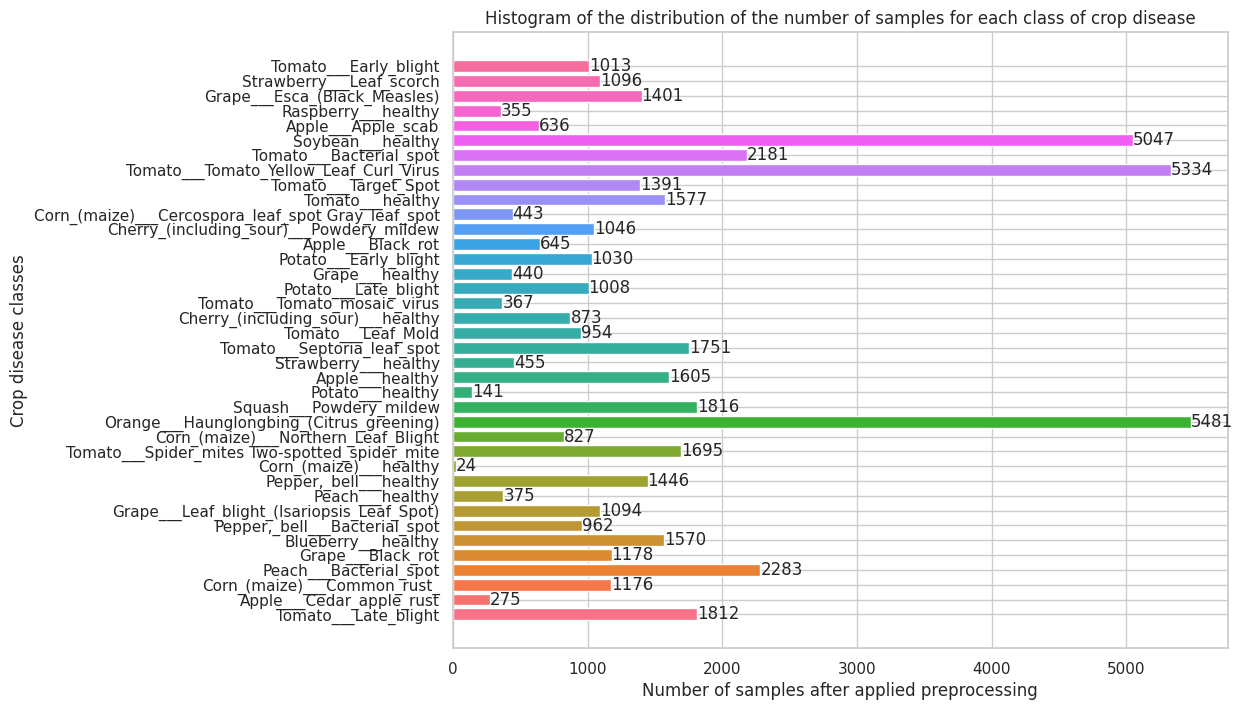

In [ ]:
class_counts = defaultdict(int)
for images, labels in mergedloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))

class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples after applied preprocessing')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [ ]:
# Combining train and validation datasets for testing the model
combined_train_set = ConcatDataset([train_set, validation_set])
combined_train_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Define hyperparameters
learning_rate = 1e-3
num_epochs = 25

network = CNN(grayscale=True).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(network):,} trainable parameters')

The model has 6,846,182 trainable parameters


In [ ]:
# Train the model
train_avg_loss, validation_avg_loss, validation_accuracy, train_accuracy = train(network, num_epochs, trainloader, validationloader, criterion, optimizer,validation_phase=True)

Epoch [1/25], Validation Loss: 1.5838, Validation Accuracy: 56.44%, Train Loss: 2.6388, Train Accuracy: 38.29%
| Epoch Time: 0m 36s
Epoch [2/25], Validation Loss: 1.1223, Validation Accuracy: 67.58%, Train Loss: 1.3046, Train Accuracy: 61.86%
| Epoch Time: 0m 39s
Epoch [3/25], Validation Loss: 0.9113, Validation Accuracy: 73.35%, Train Loss: 0.9202, Train Accuracy: 71.92%
| Epoch Time: 0m 39s
Epoch [4/25], Validation Loss: 0.8981, Validation Accuracy: 73.28%, Train Loss: 0.7335, Train Accuracy: 77.08%
| Epoch Time: 0m 46s
Epoch [5/25], Validation Loss: 0.7975, Validation Accuracy: 76.36%, Train Loss: 0.6368, Train Accuracy: 79.67%
| Epoch Time: 0m 39s
Epoch [6/25], Validation Loss: 0.7694, Validation Accuracy: 78.23%, Train Loss: 0.5579, Train Accuracy: 81.94%
| Epoch Time: 0m 38s
Epoch [7/25], Validation Loss: 0.6513, Validation Accuracy: 81.49%, Train Loss: 0.5028, Train Accuracy: 83.60%
| Epoch Time: 0m 39s
Epoch [8/25], Validation Loss: 0.6978, Validation Accuracy: 81.01%, Train Lo

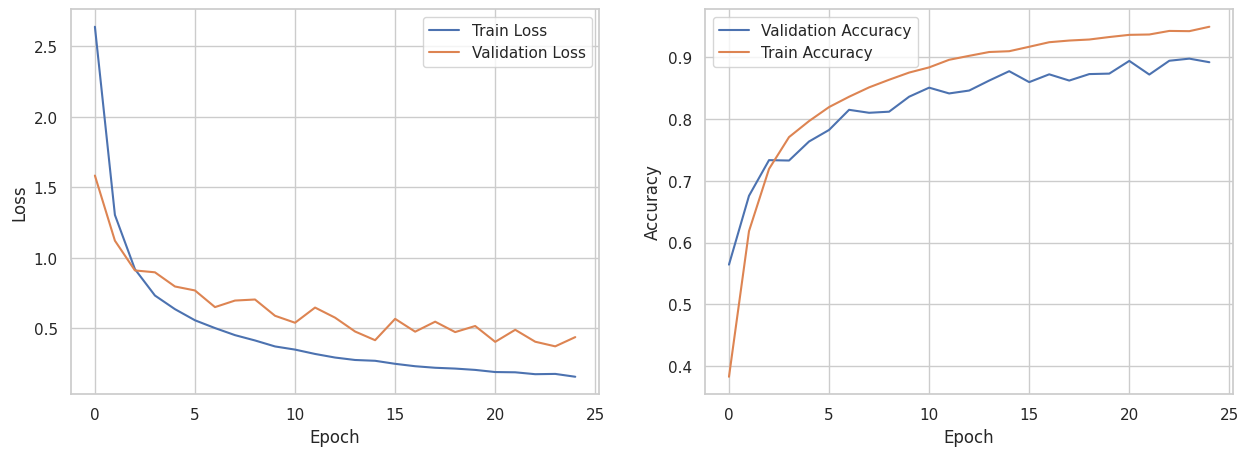

In [ ]:
plot_training_results(train_avg_loss, validation_avg_loss, train_accuracy,  validation_accuracy, is_validation=True)

In [ ]:
network = CNN(grayscale=True).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
# Test the model
train_avg_loss, test_avg_loss, test_accuracy, train_accuracy = train(network, num_epochs, combined_train_loader, testloader, criterion, optimizer,validation_phase=False)

Epoch [1/25], Test Loss: 1.5392, Test Accuracy: 55.61%, Train Loss: 2.3161, Train Accuracy: 42.37%
| Epoch Time: 0m 49s
Epoch [2/25], Test Loss: 0.8462, Test Accuracy: 73.93%, Train Loss: 1.1337, Train Accuracy: 65.83%
| Epoch Time: 0m 49s
Epoch [3/25], Test Loss: 0.6827, Test Accuracy: 78.19%, Train Loss: 0.8022, Train Accuracy: 74.74%
| Epoch Time: 0m 51s
Epoch [4/25], Test Loss: 0.6670, Test Accuracy: 78.90%, Train Loss: 0.6517, Train Accuracy: 79.43%
| Epoch Time: 0m 49s
Epoch [5/25], Test Loss: 0.5471, Test Accuracy: 82.45%, Train Loss: 0.5731, Train Accuracy: 81.68%
| Epoch Time: 0m 49s
Epoch [6/25], Test Loss: 0.4302, Test Accuracy: 85.96%, Train Loss: 0.4811, Train Accuracy: 84.48%
| Epoch Time: 0m 55s
Epoch [7/25], Test Loss: 0.7195, Test Accuracy: 79.29%, Train Loss: 0.4245, Train Accuracy: 86.39%
| Epoch Time: 0m 50s
Epoch [8/25], Test Loss: 0.3679, Test Accuracy: 87.92%, Train Loss: 0.4403, Train Accuracy: 85.76%
| Epoch Time: 0m 50s
Epoch [9/25], Test Loss: 0.4079, Test Ac

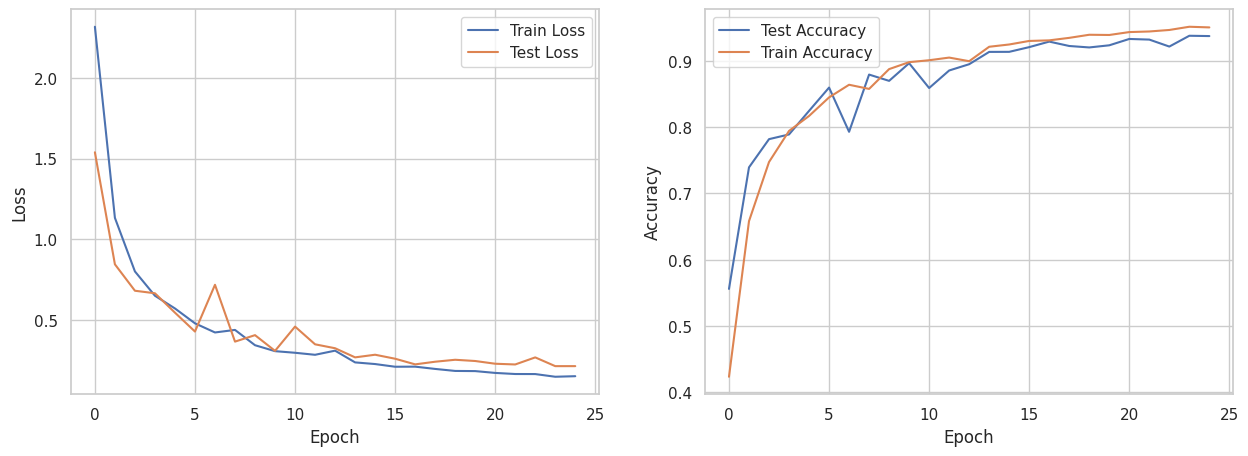

In [ ]:
plot_training_results(train_avg_loss, test_avg_loss,train_accuracy, test_accuracy, is_validation=False)

Examining the model.

In [ ]:
network.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels, probs, corrects = get_predictions(network, testloader, device)
pred_labels = torch.argmax(probs, 1)

print(f"There are {len(corrects)} correct predictions.")

There are 10562 correct predictions.


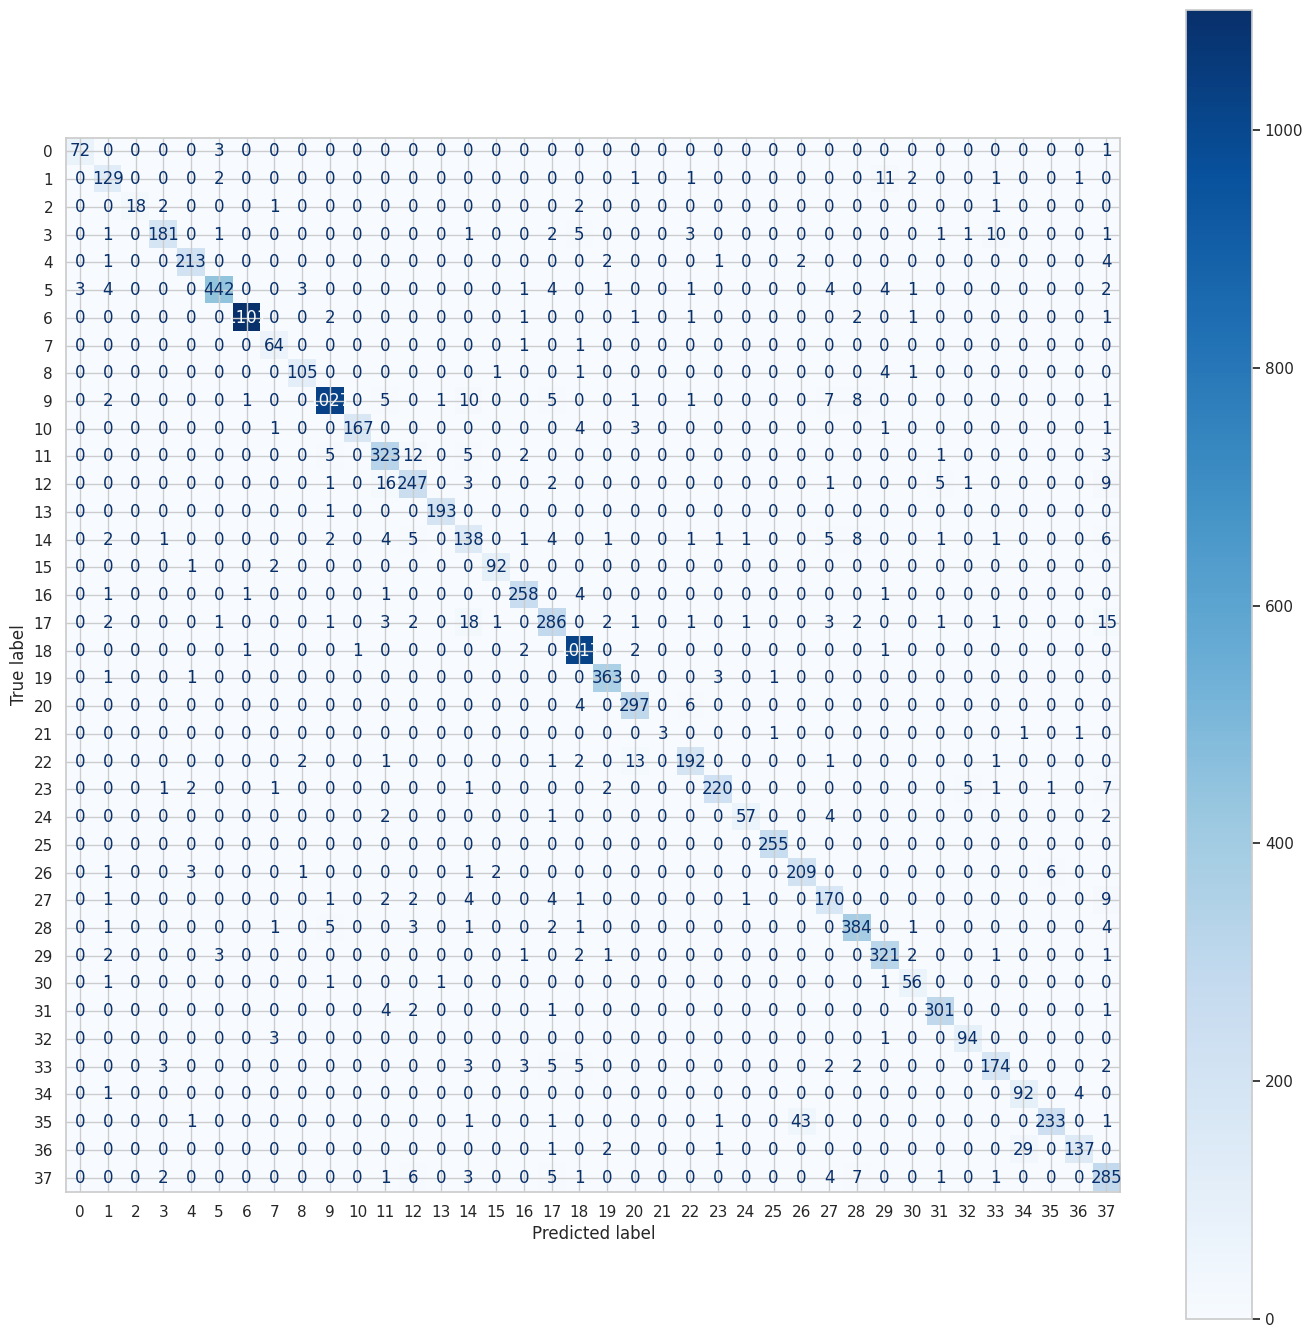

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
# Now, extract and sort incorrect examples
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)
print(f"There are {len(incorrect_examples)} incorrect predictions.")

There are 646 incorrect predictions.


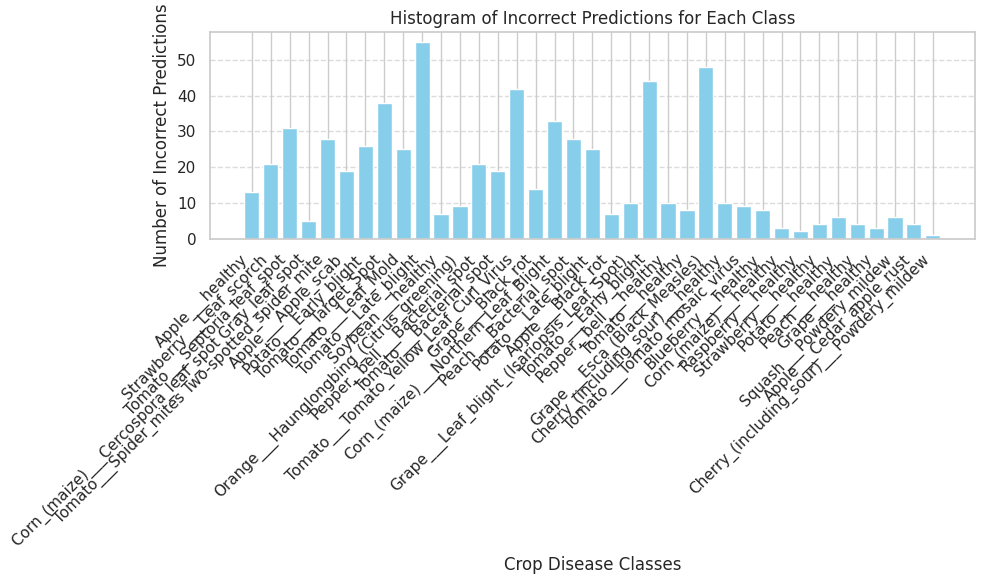

In [ ]:
incorrect_counts = {}

# Count the occurrences of each class label in the incorrect examples
for _, label, _ in incorrect_examples:
    if label.item() not in incorrect_counts:
        incorrect_counts[label.item()] = 1
    else:
        incorrect_counts[label.item()] += 1

class_names = [train_set.classes[label] for label in incorrect_counts.keys()]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_names, incorrect_counts.values(), color='skyblue')
plt.xlabel('Crop Disease Classes')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Histogram of Incorrect Predictions for Each Class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
data = {'Class Name': class_names, 'Incorrect Counts': list(incorrect_counts.values())}
df1 = pd.DataFrame(data)
df1.head(5)

Class Name  Incorrect Counts
0                                    Apple___healthy                13
1                           Strawberry___Leaf_scorch                21
2                        Tomato___Septoria_leaf_spot                31
3  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...                 5
4      Tomato___Spider_mites Two-spotted_spider_mite                28

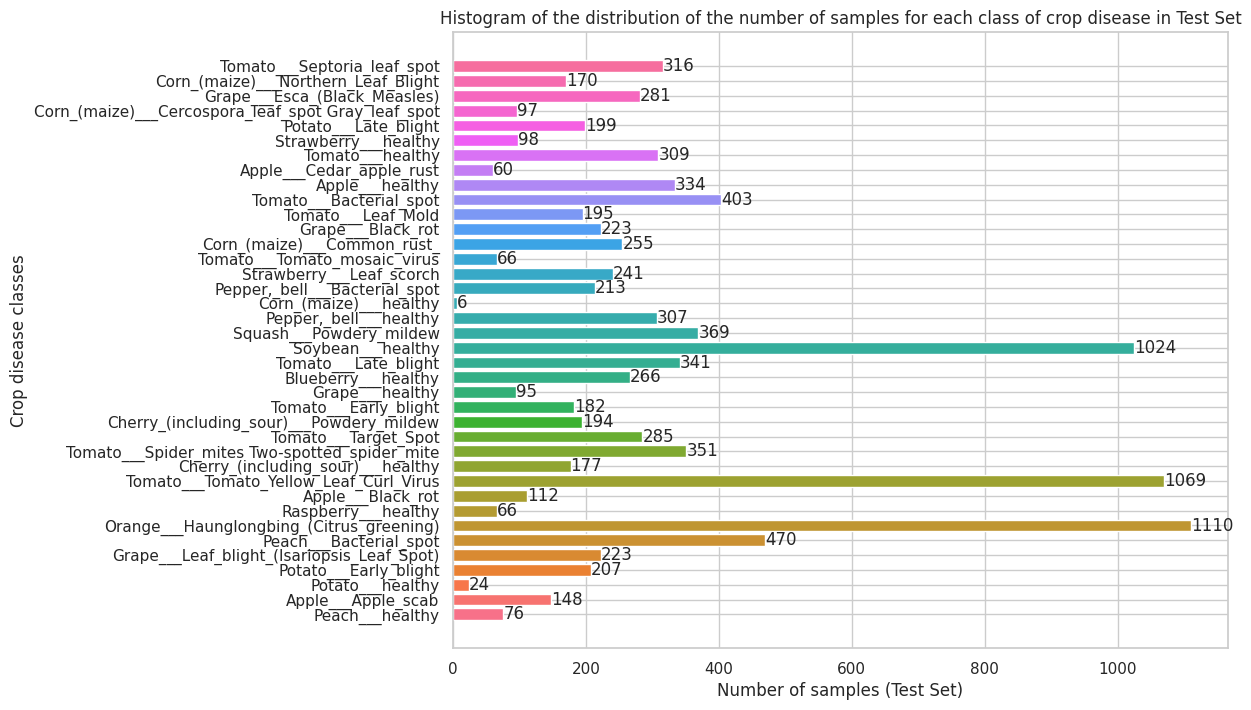

In [ ]:
class_counts = defaultdict(int)
for images, labels in testloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))


class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples (Test Set)')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease in Test Set')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [ ]:
data = {'Class Name': class_names, 'Counts': counts}
df2 = pd.DataFrame(data)
df2.head(5)

Class Name  Counts
0                             Peach___healthy      76
1                          Apple___Apple_scab     148
2                            Potato___healthy      24
3                       Potato___Early_blight     207
4  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     223

In [ ]:
merged_df = pd.merge(df1, df2, on='Class Name', suffixes=('_incorrect', '_test'))
merged_df.head(3)

Class Name  Incorrect Counts  Counts
0              Apple___healthy                13     334
1     Strawberry___Leaf_scorch                21     241
2  Tomato___Septoria_leaf_spot                31     316

In [ ]:
# Calculate the rate of success for each class in percentage
merged_df['Success Rate (%)'] = ((merged_df['Counts'] - merged_df['Incorrect Counts']) / merged_df['Counts']) * 100
merged_df

Class Name  Incorrect Counts  \
0                                     Apple___healthy                13   
1                            Strawberry___Leaf_scorch                21   
2                         Tomato___Septoria_leaf_spot                31   
3   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...                 5   
4       Tomato___Spider_mites Two-spotted_spider_mite                28   
5                                  Apple___Apple_scab                19   
6                               Potato___Early_blight                26   
7                                Tomato___Target_Spot                38   
8                                  Tomato___Leaf_Mold                25   
9                                Tomato___Late_blight                55   
10                                  Soybean___healthy                 7   
11           Orange___Haunglongbing_(Citrus_greening)                 9   
12                      Pepper,_bell___Bacterial_spot                21   
13                            Tomato___Bacterial_spot                19   
14             Tomato___Tomato_Yellow_Leaf_Curl_Virus                42   
15                                  Grape___Black_rot                14   
16                Corn_(maize)___Northern_Leaf_Blight                33   
17                             Peach___Bacterial_spot                28   
18                               Potato___Late_blight                25   
19                                  Apple___Black_rot                 7   
20         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                10   
21                              Tomato___Early_blight                44   
22                             Pepper,_bell___healthy                10   
23                                   Tomato___healthy                 8   
24                       Grape___Esca_(Black_Measles)                48   
25                  Cherry_(including_sour)___healthy                10   
26                       Tomato___Tomato_mosaic_virus                 9   
27                                Blueberry___healthy                 8   
28                             Corn_(maize)___healthy                 3   
29                                Raspberry___healthy                 2   
30                               Strawberry___healthy                 4   
31                                   Potato___healthy                 6   
32                                    Peach___healthy                 4   
33                                    Grape___healthy                 3   
34                            Squash___Powdery_mildew                 6   
35                           Apple___Cedar_apple_rust                 4   
36           Cherry_(including_sour)___Powdery_mildew                 1   

    Counts  Success Rate (%)  
0      334         96.107784  
1      241         91.286307  
2      316         90.189873  
3       97         94.845361  
4      351         92.022792  
5      148         87.162162  
6      207         87.439614  
7      285         86.666667  
8      195         87.179487  
9      341         83.870968  
10    1024         99.316406  
11    1110         99.189189  
12     213         90.140845  
13     403         95.285360  
14    1069         96.071094  
15     223         93.721973  
16     170         80.588235  
17     470         94.042553  
18     199         87.437186  
19     112         93.750000  
20     223         95.515695  
21     182         75.824176  
22     307         96.742671  
23     309         97.411003  
24     281         82.918149  
25     177         94.350282  
26      66         86.363636  
27     266         96.992481  
28       6         50.000000  
29      66         96.969697  
30      98         95.918367  
31      24         75.000000  
32      76         94.736842  
33      95         96.842105  
34     369         98.373984  
35      60         93.333333  
36     194         99.484536

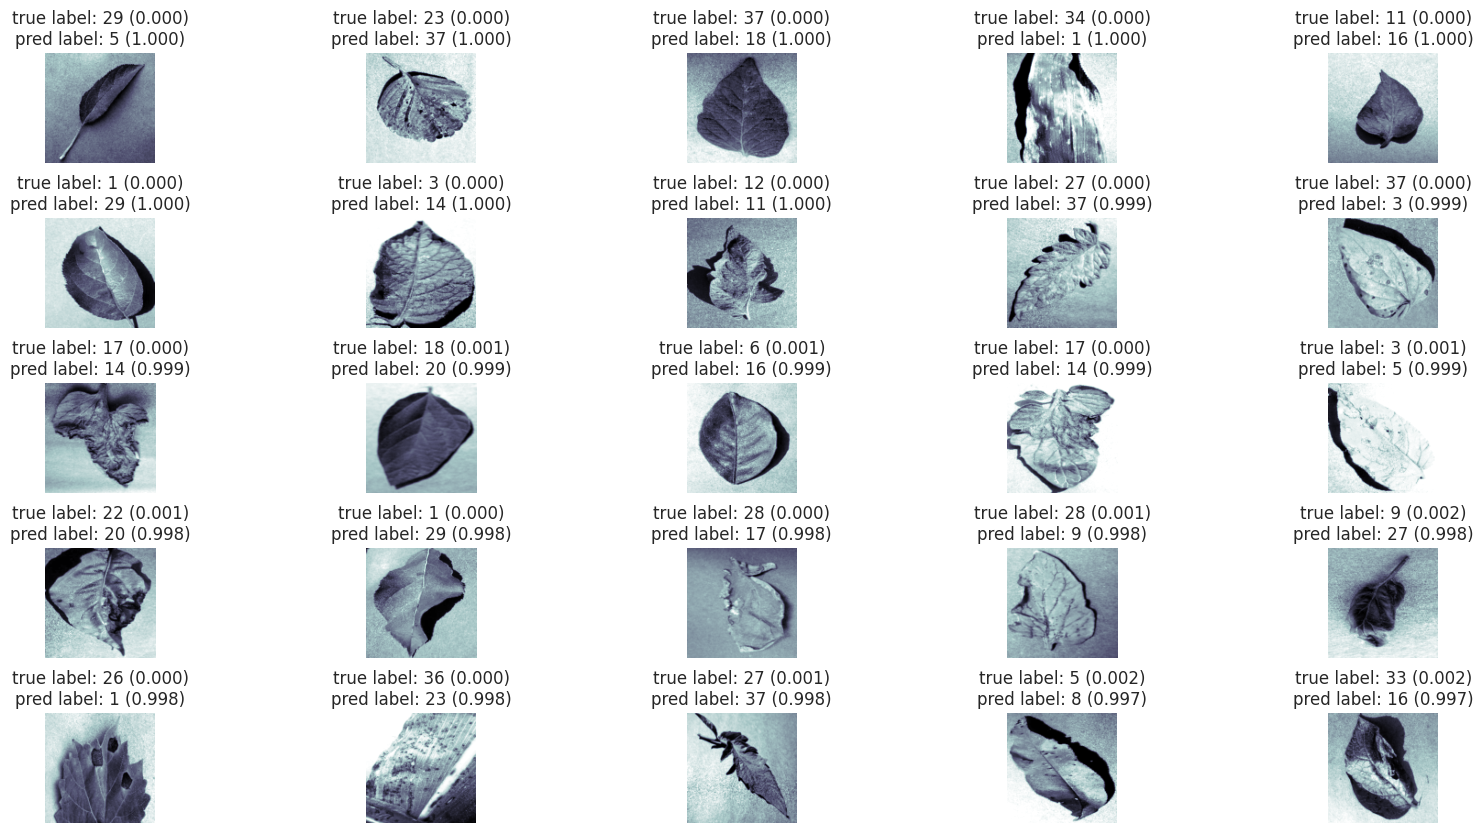

In [ ]:
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)

# D. 3) Train the model over the segmented images

In [12]:
repo_url = "https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git"
clone_dir = "plantvillage_deeplearning_paper_dataset"
subprocess.run(["git", "clone", repo_url, clone_dir])
os.chdir(clone_dir)

# Raw segmented images
classes = extract_folder(repo_url, clone_dir, "raw/segmented")

Folder 'raw/segmented' extracted successfully.
Directory 'Peach___healthy' contains 360 files.
Directory 'Apple___Apple_scab' contains 630 files.
Directory 'Potato___healthy' contains 152 files.
Directory 'Potato___Early_blight' contains 1000 files.
Directory 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' contains 1076 files.
Directory 'Peach___Bacterial_spot' contains 2297 files.
Directory 'Orange___Haunglongbing_(Citrus_greening)' contains 5507 files.
Directory 'Raspberry___healthy' contains 371 files.
Directory 'Apple___Black_rot' contains 621 files.
Directory 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' contains 5357 files.
Directory 'Cherry_(including_sour)___healthy' contains 854 files.
Directory 'Tomato___Spider_mites Two-spotted_spider_mite' contains 1676 files.
Directory 'Tomato___Target_Spot' contains 1404 files.
Directory 'Cherry_(including_sour)___Powdery_mildew' contains 1052 files.
Directory 'Tomato___Early_blight' contains 1000 files.
Directory 'Grape___healthy' contains 423 f

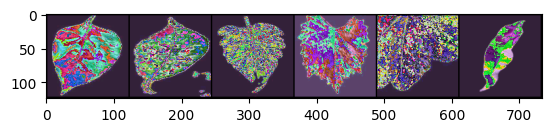

Pepper,_bell___healthy Cherry_(including_sour)___Powdery_mildew Tomato___healthy Grape___Black_rot Squash___Powdery_mildew Peach___Bacterial_spot


In [ ]:
extracted_folder = "raw/segmented"
my_dataset = CropDiseaseDataset(root_dir=extracted_folder, train=True, gray_scale=False, segmented=True)
train_loader = DataLoader(my_dataset, batch_size=6, shuffle=True, num_workers=2)

def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

images, labels = next(iter(train_loader))
show_images(utils.make_grid(images))
print(*[my_dataset.classes[l] for l in labels])

In [13]:
# Define hyperparameters
learning_rate = 1e-3
num_epochs = 25

network = CNN(grayscale=False).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

print(f'The model has {count_parameters(network):,} trainable parameters')

The model has 6,846,758 trainable parameters


In [14]:
# Splitting the dataset
extracted_folder = "raw/segmented"
train_set = CropDiseaseDataset(root_dir=extracted_folder, train=True, validation=False, gray_scale=False, segmented=True)
validation_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=True, gray_scale=False, segmented=True)
test_set = CropDiseaseDataset(root_dir=extracted_folder, train=False, validation=False, gray_scale=False, segmented=True)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
merged_dataset = ConcatDataset([train_set, validation_set, test_set])

# Create a single loader for the combined dataset
mergedloader = DataLoader(merged_dataset, batch_size=64, shuffle=True, num_workers=2)

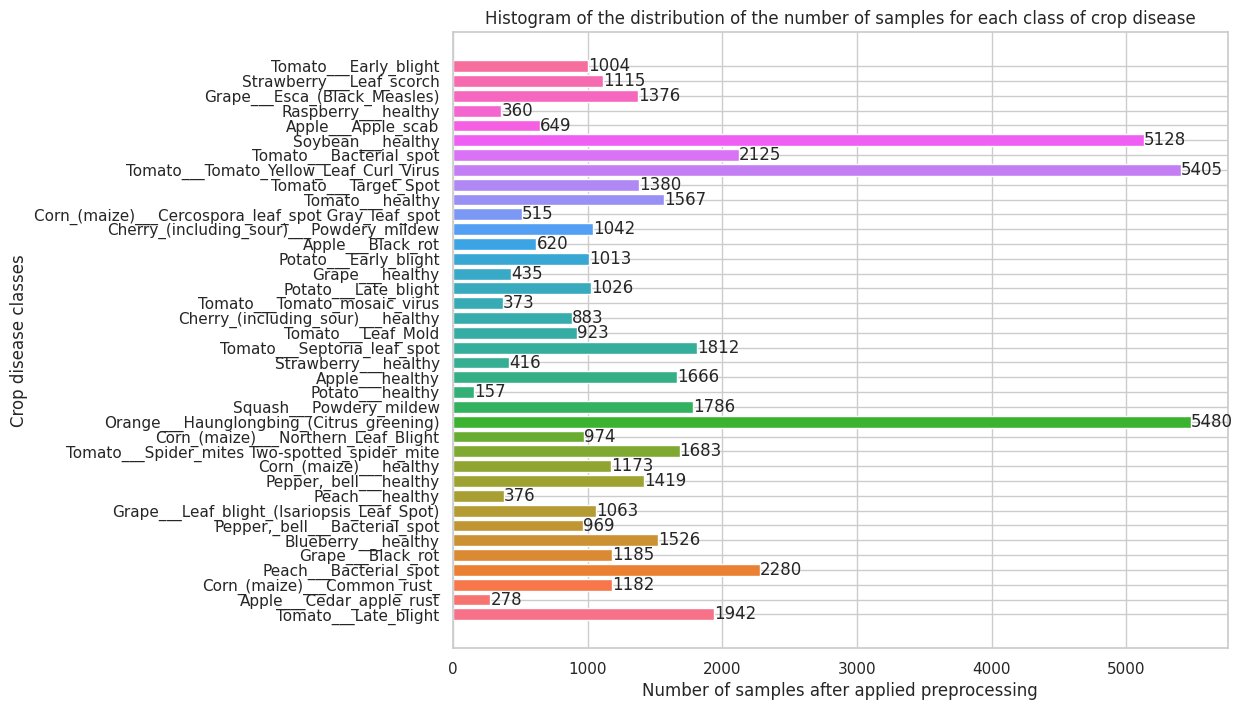

In [ ]:
class_counts = defaultdict(int)
for images, labels in mergedloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))

class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples after applied preprocessing')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [15]:
# Train the models
train_avg_loss, validation_avg_loss, validation_accuracy, train_accuracy = train(network, num_epochs, trainloader, validationloader, criterion, optimizer,validation_phase=True)

Epoch [1/25], Validation Loss: 1.5902, Validation Accuracy: 53.66%, Train Loss: 2.4395, Train Accuracy: 39.53%
| Epoch Time: 0m 33s
Epoch [2/25], Validation Loss: 0.9445, Validation Accuracy: 71.28%, Train Loss: 1.1440, Train Accuracy: 65.72%
| Epoch Time: 0m 33s
Epoch [3/25], Validation Loss: 0.7022, Validation Accuracy: 77.77%, Train Loss: 0.8136, Train Accuracy: 74.96%
| Epoch Time: 0m 33s
Epoch [4/25], Validation Loss: 0.6257, Validation Accuracy: 80.70%, Train Loss: 0.6591, Train Accuracy: 78.97%
| Epoch Time: 0m 33s
Epoch [5/25], Validation Loss: 0.5460, Validation Accuracy: 82.81%, Train Loss: 0.5581, Train Accuracy: 82.41%
| Epoch Time: 0m 33s
Epoch [6/25], Validation Loss: 0.5431, Validation Accuracy: 82.75%, Train Loss: 0.4900, Train Accuracy: 83.98%
| Epoch Time: 0m 33s
Epoch [7/25], Validation Loss: 0.4567, Validation Accuracy: 85.45%, Train Loss: 0.4474, Train Accuracy: 85.53%
| Epoch Time: 0m 34s
Epoch [8/25], Validation Loss: 0.4163, Validation Accuracy: 86.59%, Train Lo

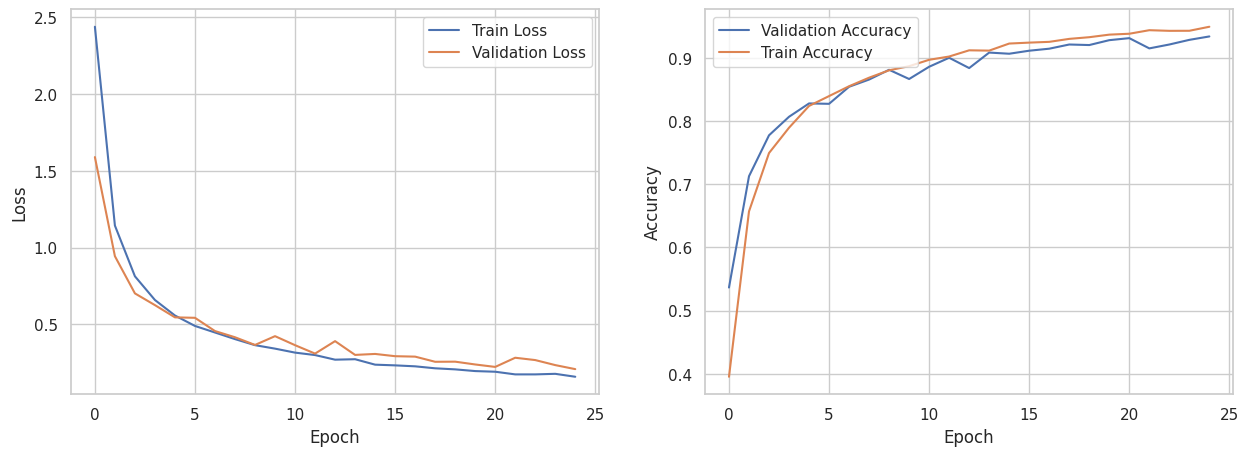

In [16]:
plot_training_results(train_avg_loss, validation_avg_loss,train_accuracy , validation_accuracy, is_validation=True)

In [17]:
# Combining train and validation datasets for testing the model
combined_train_set = ConcatDataset([train_set, validation_set])
combined_train_loader = torch.utils.data.DataLoader(combined_train_set, batch_size=64, shuffle=True, num_workers=2)

In [ ]:
# Test the model
num_epochs = 20
network = CNN(grayscale=False).to(device)
network.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [18]:
train_avg_loss, test_avg_loss, test_accuracy, train_accuracy = train(network, num_epochs, combined_train_loader, testloader, criterion, optimizer,validation_phase=False)

Epoch [1/20], Test Loss: 1.2874, Test Accuracy: 61.92%, Train Loss: 2.2362, Train Accuracy: 43.31%
| Epoch Time: 0m 45s
Epoch [2/20], Test Loss: 0.8011, Test Accuracy: 75.24%, Train Loss: 1.0310, Train Accuracy: 68.80%
| Epoch Time: 0m 45s
Epoch [3/20], Test Loss: 0.6246, Test Accuracy: 79.74%, Train Loss: 0.7267, Train Accuracy: 77.19%
| Epoch Time: 0m 45s
Epoch [4/20], Test Loss: 0.5710, Test Accuracy: 81.90%, Train Loss: 0.5921, Train Accuracy: 81.13%
| Epoch Time: 0m 45s
Epoch [5/20], Test Loss: 0.4594, Test Accuracy: 85.25%, Train Loss: 0.4905, Train Accuracy: 84.27%
| Epoch Time: 0m 45s
Epoch [6/20], Test Loss: 0.4012, Test Accuracy: 86.83%, Train Loss: 0.4298, Train Accuracy: 85.98%
| Epoch Time: 0m 44s
Epoch [7/20], Test Loss: 0.4067, Test Accuracy: 87.22%, Train Loss: 0.3769, Train Accuracy: 87.67%
| Epoch Time: 0m 43s
Epoch [8/20], Test Loss: 0.3551, Test Accuracy: 88.55%, Train Loss: 0.3372, Train Accuracy: 88.93%
| Epoch Time: 0m 45s
Epoch [9/20], Test Loss: 0.3377, Test Ac

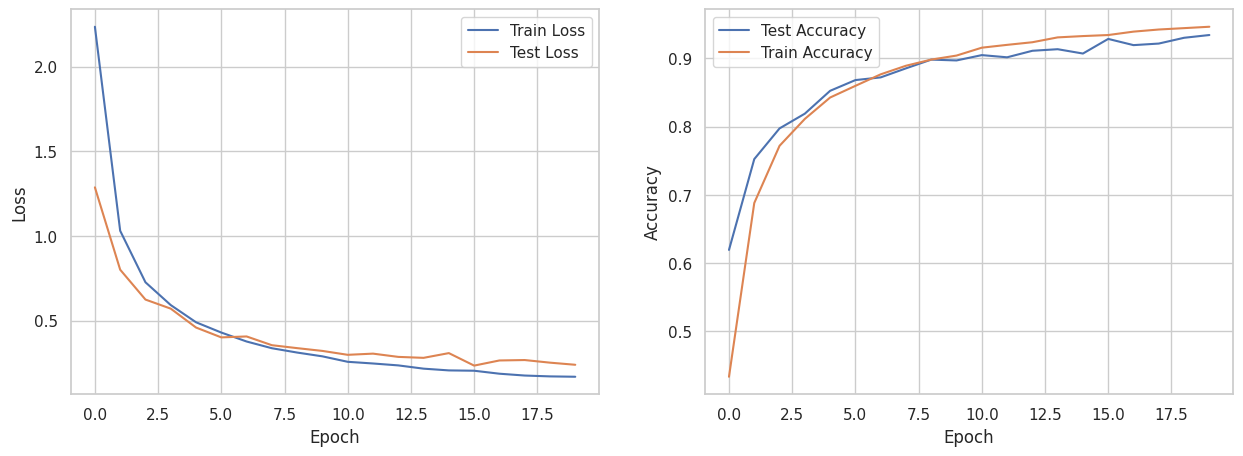

In [19]:
plot_training_results(train_avg_loss, test_avg_loss, train_accuracy, test_accuracy, is_validation=False)

Examining the model

In [20]:
network.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels, probs, corrects = get_predictions(network, testloader, device)
pred_labels = torch.argmax(probs, 1)

print(f"There are {len(corrects)} correct predictions.")

There are 10863 correct predictions.


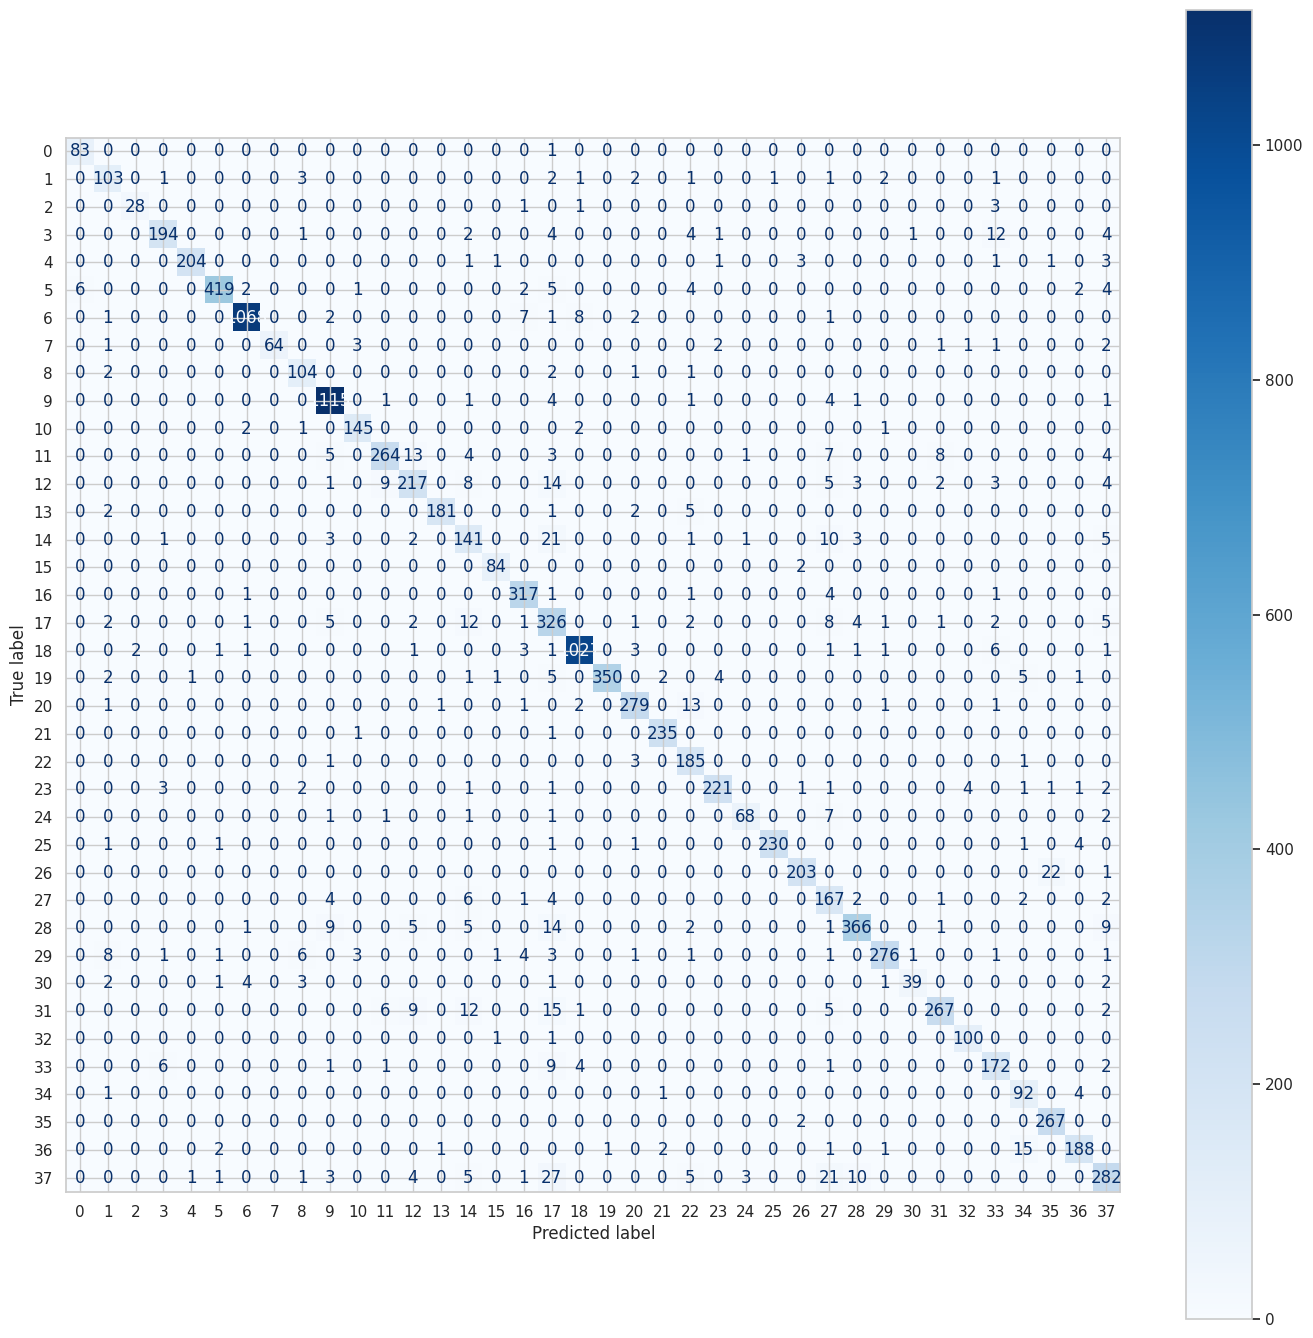

In [22]:
plot_confusion_matrix(labels, pred_labels)

In [23]:
# Now, extract and sort incorrect examples
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)
print(f"There are {len(incorrect_examples)} incorrect predictions.")

There are 792 incorrect predictions.


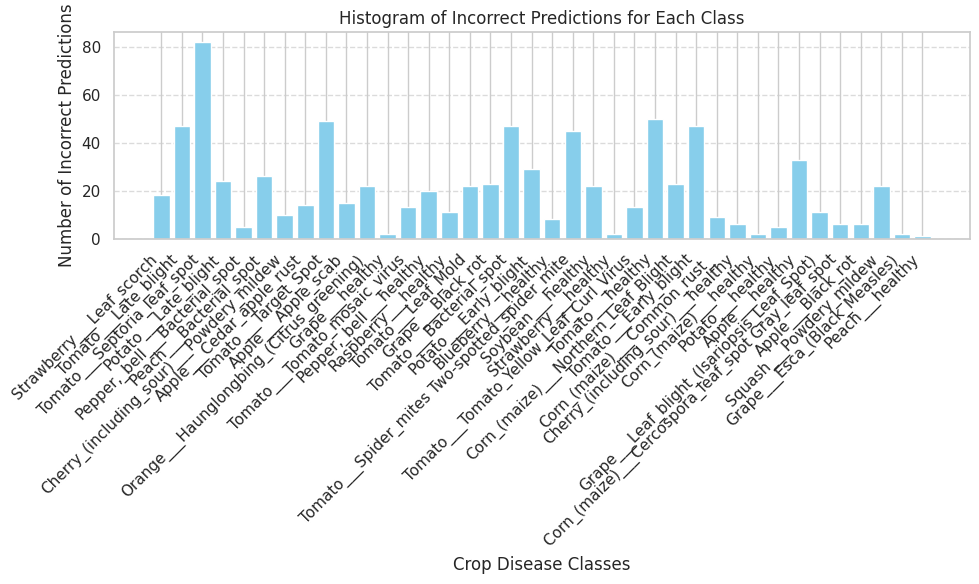

In [24]:
incorrect_counts = {}

# Count the occurrences of each class label in the incorrect examples
for _, label, _ in incorrect_examples:
    if label.item() not in incorrect_counts:
        incorrect_counts[label.item()] = 1
    else:
        incorrect_counts[label.item()] += 1

class_names = [train_set.classes[label] for label in incorrect_counts.keys()]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_names, incorrect_counts.values(), color='skyblue')
plt.xlabel('Crop Disease Classes')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Histogram of Incorrect Predictions for Each Class')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
data = {'Class Name': class_names, 'Incorrect Counts': list(incorrect_counts.values())}
df1 = pd.DataFrame(data)
df1.head(5)

Class Name  Incorrect Counts
0       Strawberry___Leaf_scorch                18
1           Tomato___Late_blight                47
2    Tomato___Septoria_leaf_spot                82
3           Potato___Late_blight                24
4  Pepper,_bell___Bacterial_spot                 5

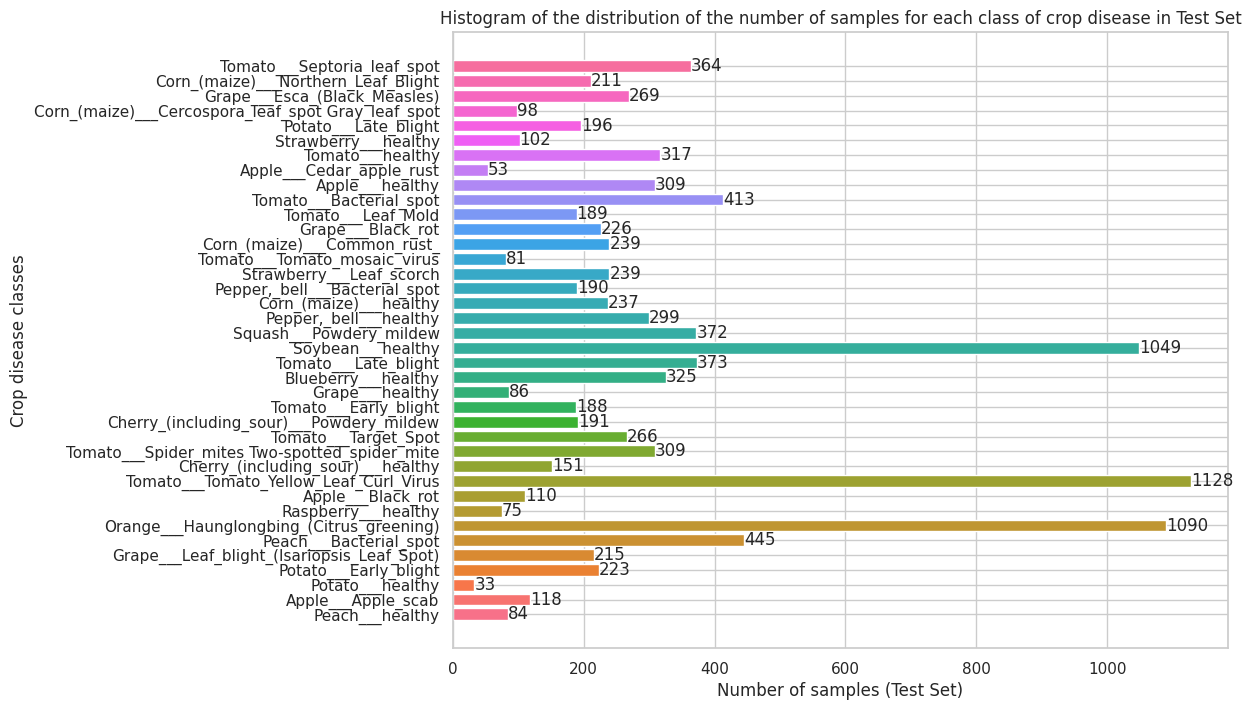

In [26]:
class_counts = defaultdict(int)
for images, labels in testloader:
    for label in labels:
        class_counts[label.item()] += 1

class_labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in class_labels]
colors = sns.color_palette("husl", len(class_labels))


class_names = [train_set.classes[label] for label in class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, counts, color=colors)
plt.xlabel('Number of samples (Test Set)')
plt.ylabel('Crop disease classes')
plt.title('Histogram of the distribution of the number of samples for each class of crop disease in Test Set')

for i, (count, name) in enumerate(zip(counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

In [27]:
data = {'Class Name': class_names, 'Counts': counts}
df2 = pd.DataFrame(data)
df2.head(5)

Class Name  Counts
0                             Peach___healthy      84
1                          Apple___Apple_scab     118
2                            Potato___healthy      33
3                       Potato___Early_blight     223
4  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     215

In [28]:
merged_df = pd.merge(df1, df2, on='Class Name', suffixes=('_incorrect', '_test'))
merged_df.head(3)

Class Name  Incorrect Counts  Counts
0     Strawberry___Leaf_scorch                18     239
1         Tomato___Late_blight                47     373
2  Tomato___Septoria_leaf_spot                82     364

In [29]:
# Calculate the rate of success for each class in percentage
merged_df['Success Rate (%)'] = ((merged_df['Counts'] - merged_df['Incorrect Counts']) / merged_df['Counts']) * 100
merged_df

Class Name  Incorrect Counts  \
0                            Strawberry___Leaf_scorch                18   
1                                Tomato___Late_blight                47   
2                         Tomato___Septoria_leaf_spot                82   
3                                Potato___Late_blight                24   
4                       Pepper,_bell___Bacterial_spot                 5   
5                              Peach___Bacterial_spot                26   
6            Cherry_(including_sour)___Powdery_mildew                10   
7                            Apple___Cedar_apple_rust                14   
8                                Tomato___Target_Spot                49   
9                                  Apple___Apple_scab                15   
10           Orange___Haunglongbing_(Citrus_greening)                22   
11                                    Grape___healthy                 2   
12                       Tomato___Tomato_mosaic_virus                13   
13                             Pepper,_bell___healthy                20   
14                                Raspberry___healthy                11   
15                                 Tomato___Leaf_Mold                22   
16                                  Grape___Black_rot                23   
17                            Tomato___Bacterial_spot                47   
18                              Potato___Early_blight                29   
19                                Blueberry___healthy                 8   
20      Tomato___Spider_mites Two-spotted_spider_mite                45   
21                                  Soybean___healthy                22   
22                               Strawberry___healthy                 2   
23             Tomato___Tomato_Yellow_Leaf_Curl_Virus                13   
24                                   Tomato___healthy                50   
25                Corn_(maize)___Northern_Leaf_Blight                23   
26                              Tomato___Early_blight                47   
27                        Corn_(maize)___Common_rust_                 9   
28                  Cherry_(including_sour)___healthy                 6   
29                             Corn_(maize)___healthy                 2   
30                                   Potato___healthy                 5   
31                                    Apple___healthy                33   
32         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                11   
33  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...                 6   
34                                  Apple___Black_rot                 6   
35                            Squash___Powdery_mildew                22   
36                       Grape___Esca_(Black_Measles)                 2   
37                                    Peach___healthy                 1   

    Counts  Success Rate (%)  
0      239         92.468619  
1      373         87.399464  
2      364         77.472527  
3      196         87.755102  
4      190         97.368421  
5      445         94.157303  
6      191         94.764398  
7       53         73.584906  
8      266         81.578947  
9      118         87.288136  
10    1090         97.981651  
11      86         97.674419  
12      81         83.950617  
13     299         93.311037  
14      75         85.333333  
15     189         88.359788  
16     226         89.823009  
17     413         88.619855  
18     223         86.995516  
19     325         97.538462  
20     309         85.436893  
21    1049         97.902765  
22     102         98.039216  
23    1128         98.847518  
24     317         84.227129  
25     211         89.099526  
26     188         75.000000  
27     239         96.234310  
28     151         96.026490  
29     237         99.156118  
30      33         84.848485  
31     309         89.320388  
32     215         94.883721  
33      98         93.877551  
34     110         94.545455  
3

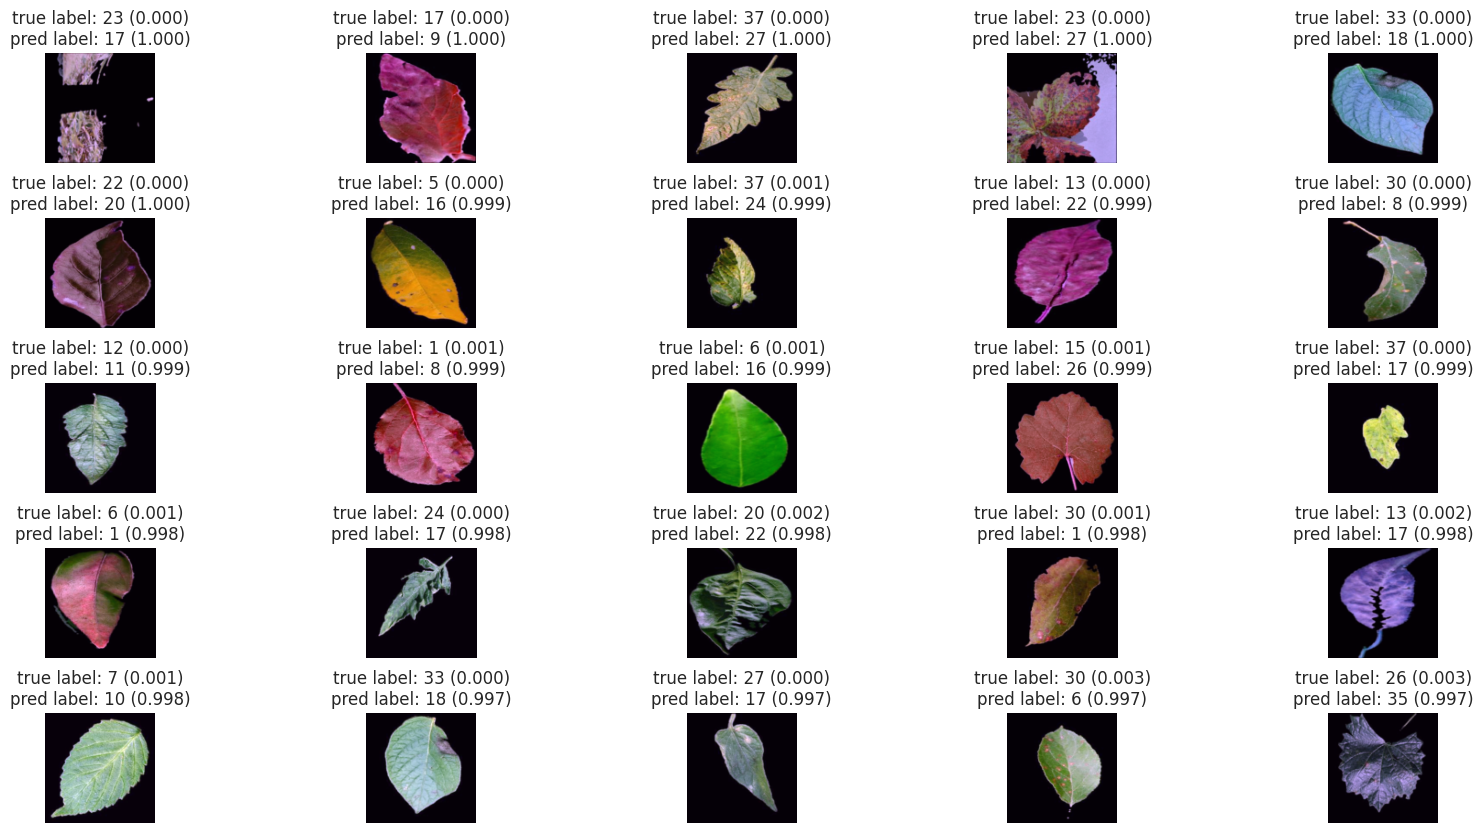

In [30]:
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)